# arXiv Monthly Submissions & Downloads

### Caveats
Here are some caveats to consider, taken from the [arXiv website](https://arxiv.org).
> _While we have attempted to extract download data representing unique full-text downloads by real users, there are many factors which affect accuracy. These factors include:_
    >>1. _the data is from the main [arXiv site](https://arxiv.org) and the arXiv mirrors, though some mirror data is incomplete;_
    >>2. _only web downloads are included (and not FTP or email "downloads" that were formerly supported);_
    >>3. _we have counted downloads according to the COUNTER algorithm which excludes rapid repeat downloads;_
    >>4. _we have attempted to identify and remove robot or automated downloads from the count (false positives lead to undercounting, failing to identify robots leads to overcounting);_
    >>5. _data prior to 2009 has not been cleaned with as much care as later data, it shows trends nonetheless._

In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

# The usual suspects ...
import time_series as ts
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels

# And their accomplices ...
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

# Plotting settings
sns.set(context='notebook', style='whitegrid', palette='deep', rc=None)

In [2]:
# Getting the data
downloads = pd.read_csv(
    'get_monthly_downloads_extracted_05-04-2018.csv')
submissions = pd.read_csv(
    'get_monthly_submissions_extracted-05-04-2018.csv')
data = pd.merge(submissions, downloads, on='month')

# Create a new file with the combined data
data.to_csv(
    'combined_submissions_and_downloads.csv', 
    sep=',')

Inspecting the dataset.

In [3]:
# Top 10 rows
data.head(10)

,month,submissions,historical_delta,downloads
0,1994-01,582,-28,0
1,1994-02,634,-19,1863
2,1994-03,729,-24,7048
3,1994-04,699,-39,6814
4,1994-05,823,-18,9601
5,1994-06,856,-32,11007
6,1994-07,840,-23,9488
7,1994-08,746,-20,10789
8,1994-09,851,-33,12872
9,1994-10,909,-23,16260


In [4]:
# Description
data.describe()

,submissions,historical_delta,downloads
count,290.000000,290.000000,2.900000e+02
mean,4662.703448,-6.575862,3.709525e+06
std,2803.957369,11.616244,4.453700e+06
min,582.000000,-49.000000,0.000000e+00
25%,2428.500000,-7.000000,6.735292e+05
50%,4112.500000,0.000000,2.067751e+06
75%,6726.000000,0.000000,4.982482e+06
max,11627.000000,0.000000,1.943365e+07


In [5]:
# Missing data
data.isnull().sum()

month               0
submissions         0
historical_delta    0
downloads           0
dtype: int64

| Columns | Description | Data Type | Action |
| :---: | :---: | :---: | :---: |
| `month` | month of activity | `string` | change to `datetime` |
| `submissions` | number of submissions made on a particular month | `integer` | do nothing |
| `historical_delta` | _undefined_ | `integer` | do nothing |
| `downloads` | number of downloads made on a particular month | `integer` | do nothing |
 
Our dataset has 4 columns and 290 rows. There are no missing values. We'll now proceed with further cleaning of our data.

In [6]:
# Changing month to 'datetime'
data.month = pd.to_datetime(data.month, yearfirst=True, format="%Y-%m")
data.dtypes

month               datetime64[ns]
submissions                  int64
historical_delta             int64
downloads                    int64
dtype: object

We have successfully changed the `month` into a _datetime_ object.

***

### Number of submissions and downloads

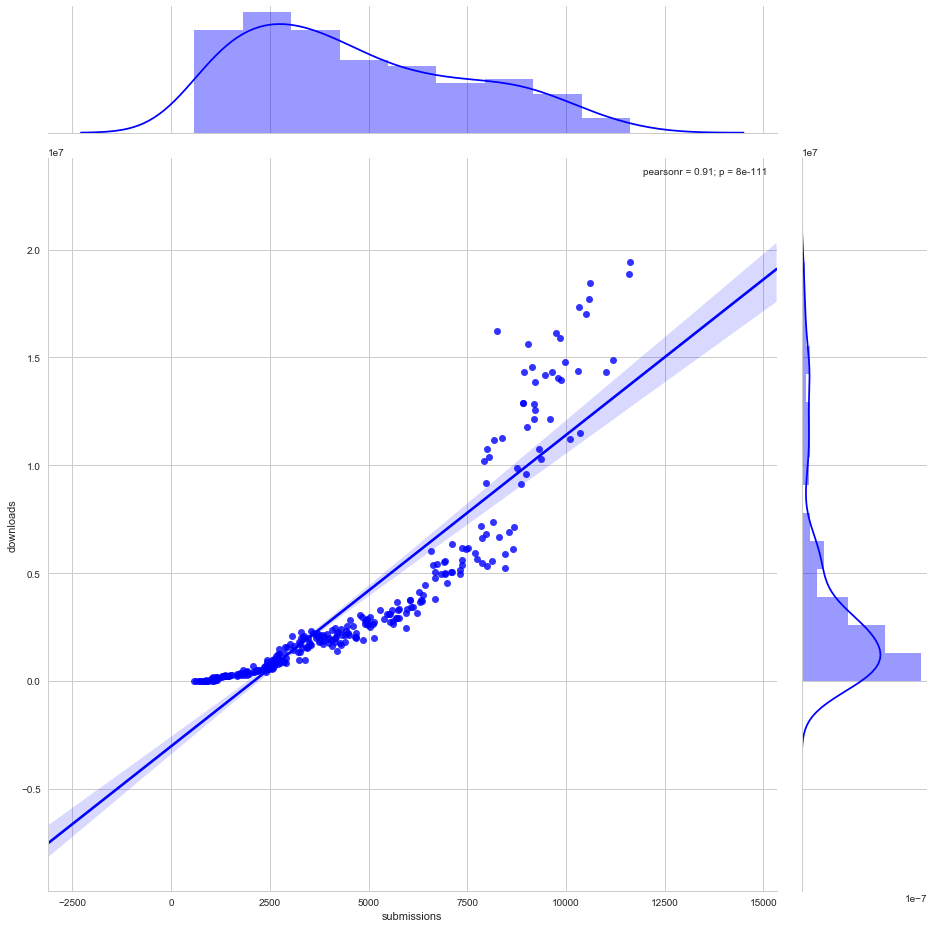

In [7]:
# Number of submissions vs. number of downloads
filterwarnings('ignore')
sns.jointplot(data=data, x='submissions', y='downloads', color='blue', kind='reg', size=13, )

Plotting the number of submissions against downloads, we find a strong linear correlation of $.91$ between the two variables. This tells us that as the number of submissions increases, so does the number of downloads.

From the scatterplot, we also find that submissions are more densely distributed in the range of $1 - 8000$. While on the other hand, downloads are more densely distributed in the range of $0 - 7.5$ million.

***

### Historical Delta ($h_\delta$)

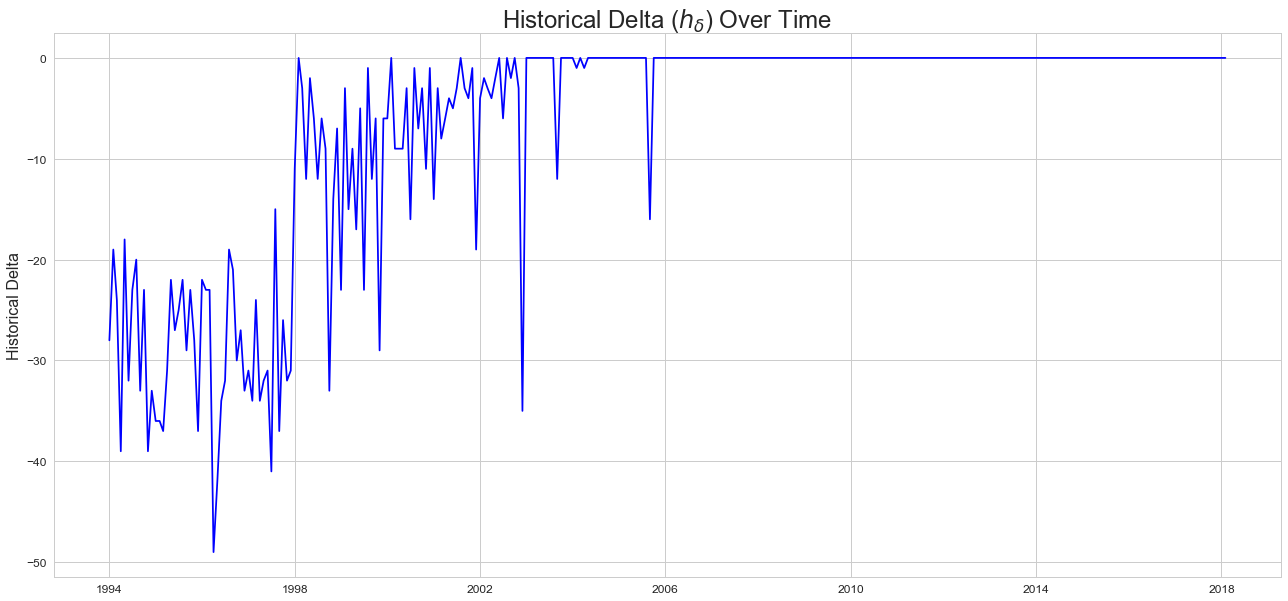

In [8]:
# Creating the time series
h = data[['month', 'historical_delta']]
historical_delta = h.set_index('month')['historical_delta']

# Historical delta over time
ts.plot_series(historical_delta, title='Historical Delta ($h_{\delta}$) Over Time', ylabel='Historical Delta')

#### Stationarity of Historical Delta ($h_{\delta}$)

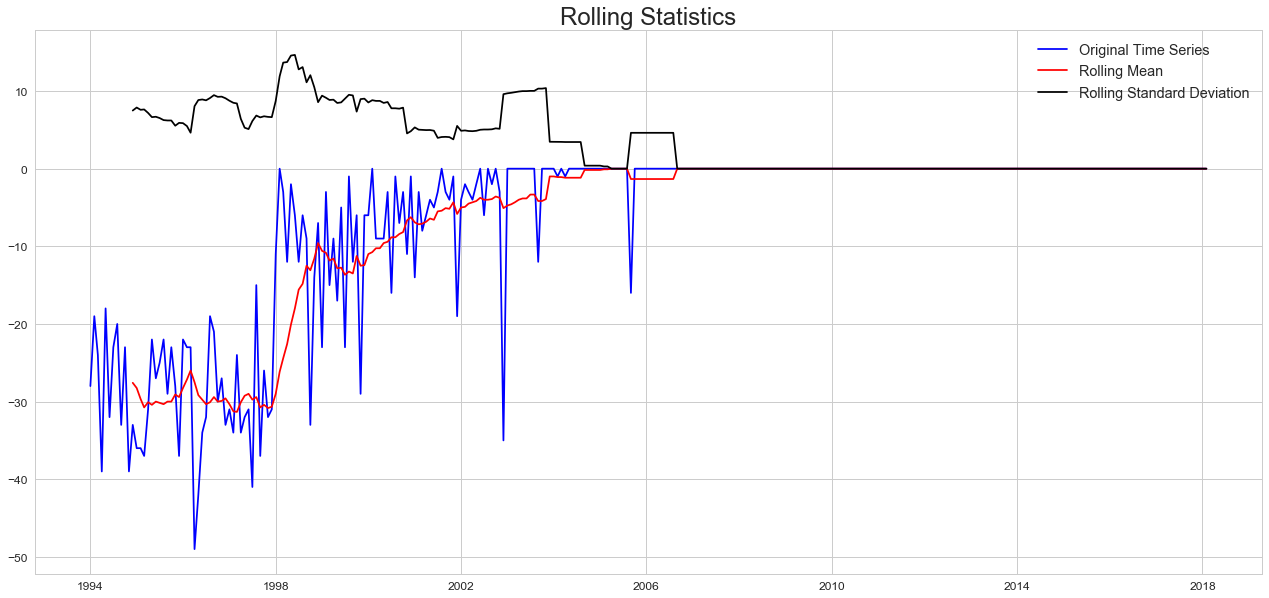

Results of Dickey-Fuller Test:
Test Statistic                  -2.263350
p-value                          0.184061
Number of Lags Used             11.000000
Number of Observations Used    278.000000
Critical Value (1%)             -3.454094
Critical Value (5%)             -2.871993
Critical Value (10%)            -2.572340
dtype: float64


In [9]:
ts.test_stationarity(historical_delta)

#### Summary

**insert summary here**

The _historical delta_ does not seem to show and trend or seasonality overtime. There are severe flactuations in the earlier years between $1994 - 2003$. After this period, the values are flatter along $0$.

Results from the Dickey-Fuller test show a test statistic value of $-2.27$, which is close to the critical values, further justifying a lack of trend.

***

### Submissions

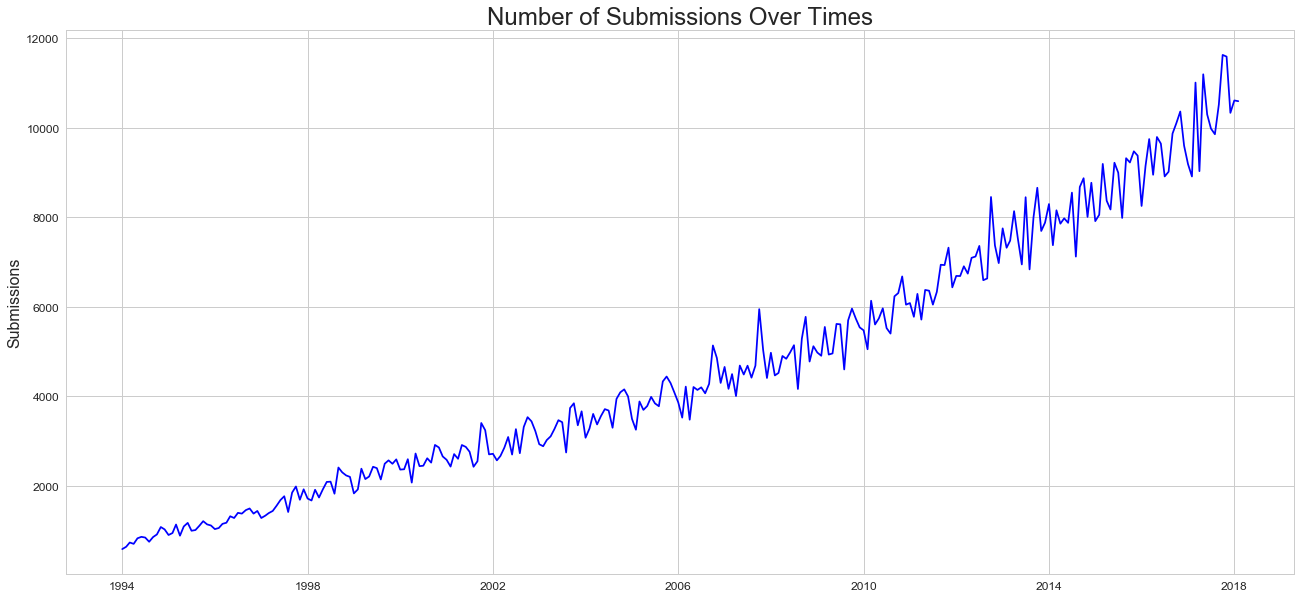

In [10]:
# Creating the submissions time series
s = data[['month', 'submissions']]
submissions = s.set_index('month')['submissions']

# Number of submissions over time
ts.plot_series(submissions, title='Number of Submissions Over Times', ylabel='Submissions')

There has been a general upward trend in the number of submissions from $1994 - 2017$. There are relatively fewer flactuations in the period between $1994 - 2002$ compared to the period between $2003$ to the present date.

#### Stationarity of Submissions

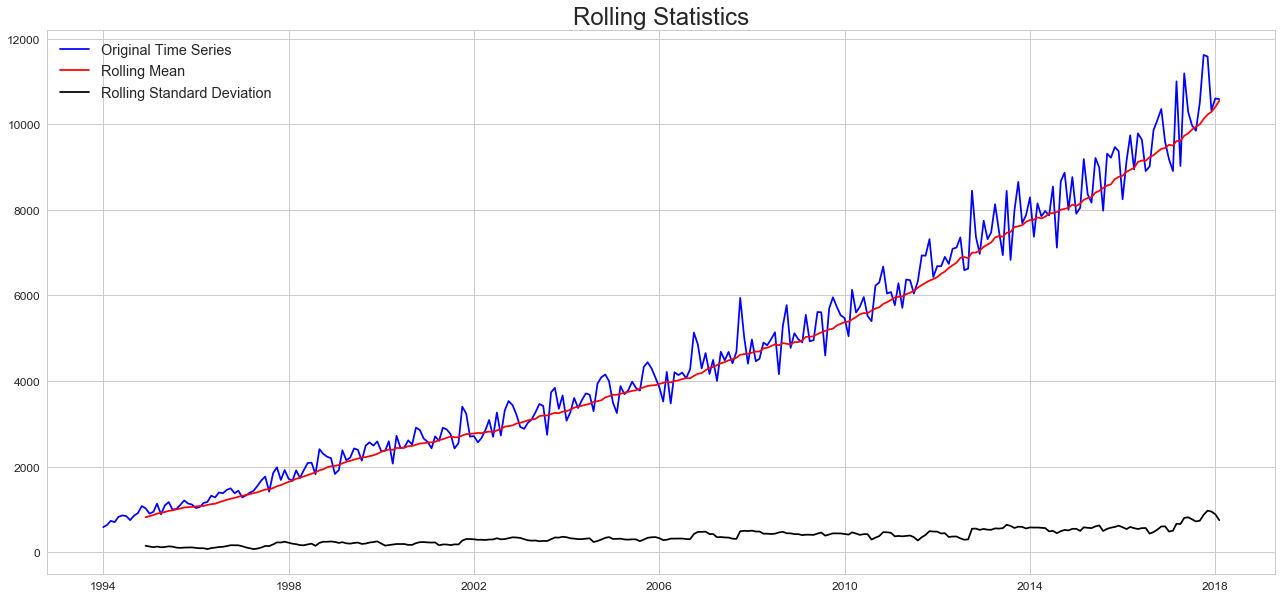

Results of Dickey-Fuller Test:
Test Statistic                   4.476636
p-value                          1.000000
Number of Lags Used             15.000000
Number of Observations Used    274.000000
Critical Value (1%)             -3.454444
Critical Value (5%)             -2.872147
Critical Value (10%)            -2.572422
dtype: float64


In [11]:
ts.test_stationarity(submissions)

We clearly have a rising trend over time. _This is not a stationary time series_. This can be observed from the rising mean, even though the standard deviation remains low.

We will now try to reducing the trend using logarithms. The intention is to penalize higher values more than lower values resulting in a flatter or less steeep trend.

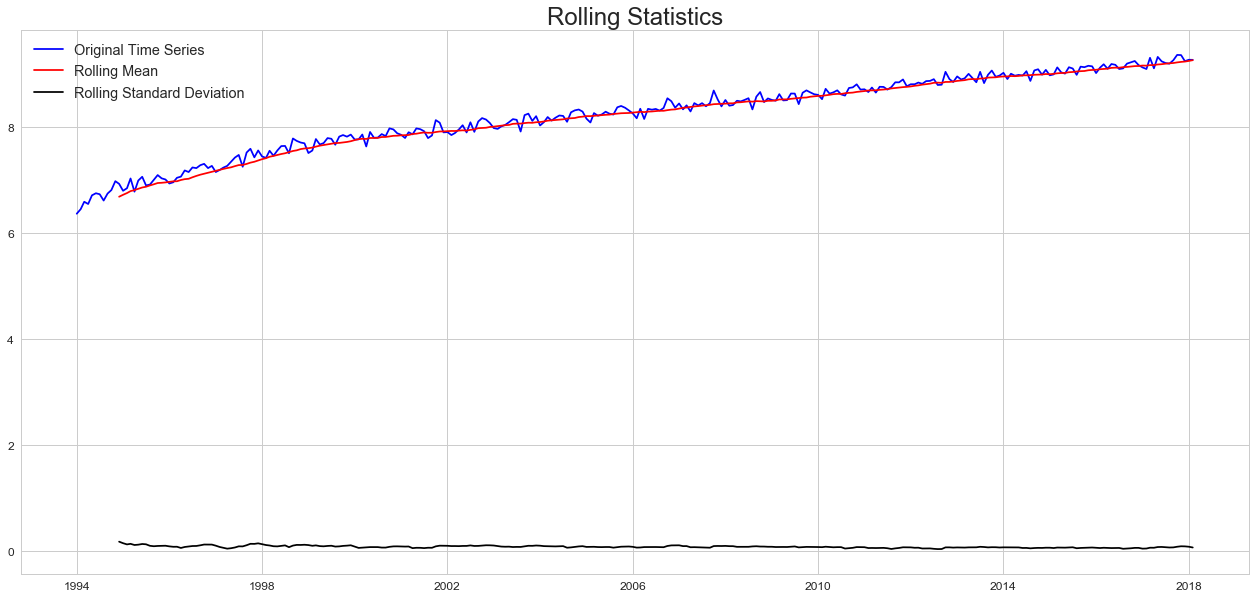

Results of Dickey-Fuller Test:
Test Statistic                  -3.579391
p-value                          0.006167
Number of Lags Used             14.000000
Number of Observations Used    275.000000
Critical Value (1%)             -3.454355
Critical Value (5%)             -2.872108
Critical Value (10%)            -2.572401
dtype: float64


In [12]:
# Reducing the trend by applying logarithms
submissions_log = np.log(submissions)

# Testing for stationarity
ts.test_stationarity(submissions_log)

The logarithms have tried to remove some of the steep trend and has also made the standard much more flat. However, closer inspection shows that we still have a rising trend

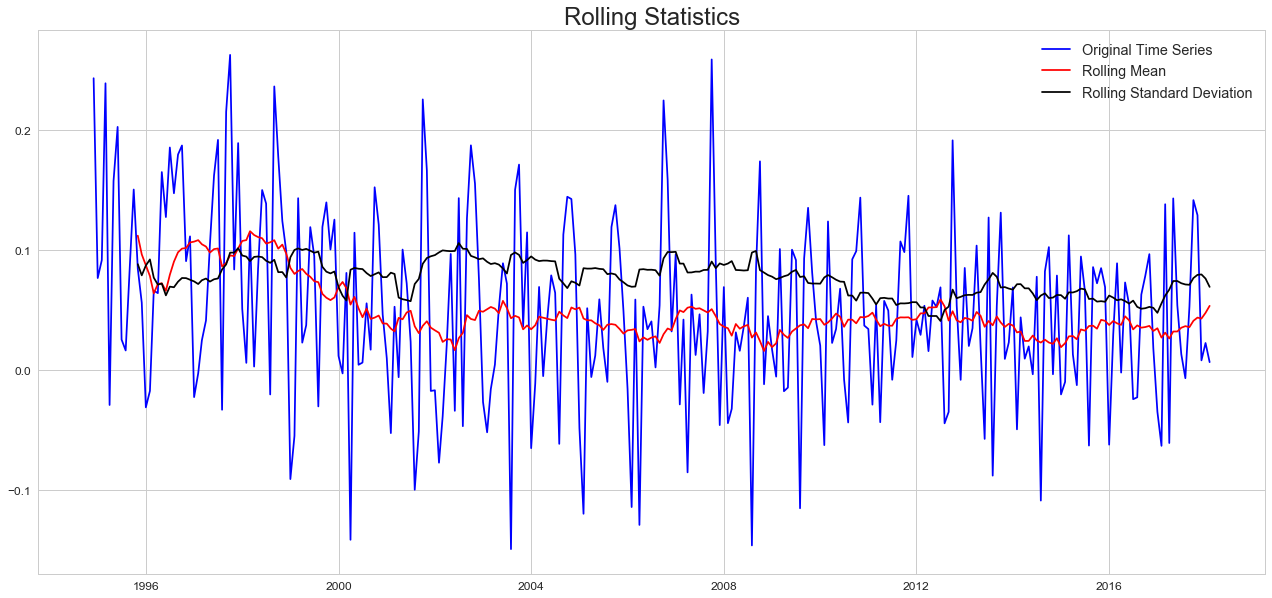

Results of Dickey-Fuller Test:
Test Statistic                  -1.985940
p-value                          0.292772
Number of Lags Used             14.000000
Number of Observations Used    264.000000
Critical Value (1%)             -3.455365
Critical Value (5%)             -2.872551
Critical Value (10%)            -2.572638
dtype: float64


In [13]:
# Removing the rolling mean
submissions_log_diff = submissions_log - submissions_log.rolling(window=12, center=False).mean().dropna()
submissions_log_diff.dropna(inplace=True)
ts.test_stationarity(submissions_log_diff)

(array([  6. ,   6.5,   7. ,   7.5,   8. ,   8.5,   9. ,   9.5,  10. ]),
 <a list of 9 Text yticklabel objects>)

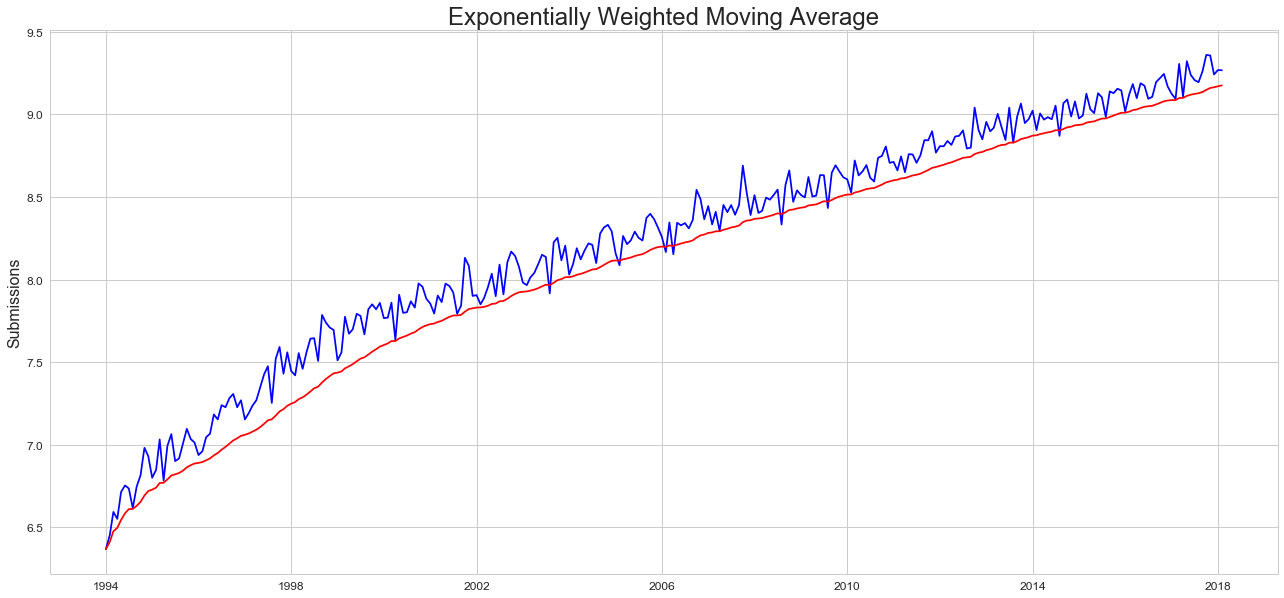

In [14]:
# Exponentially weighted moving average
ewa = submissions_log.ewm(halflife=12).mean()
plt.figure(figsize=(22, 10))
plt.plot(submissions_log, color='blue')
plt.plot(ewa, color='red')
plt.title('Exponentially Weighted Moving Average', fontsize=24)
plt.xticks(fontsize=12)
plt.ylabel('Submissions', fontsize=16)
plt.yticks(fontsize=12)

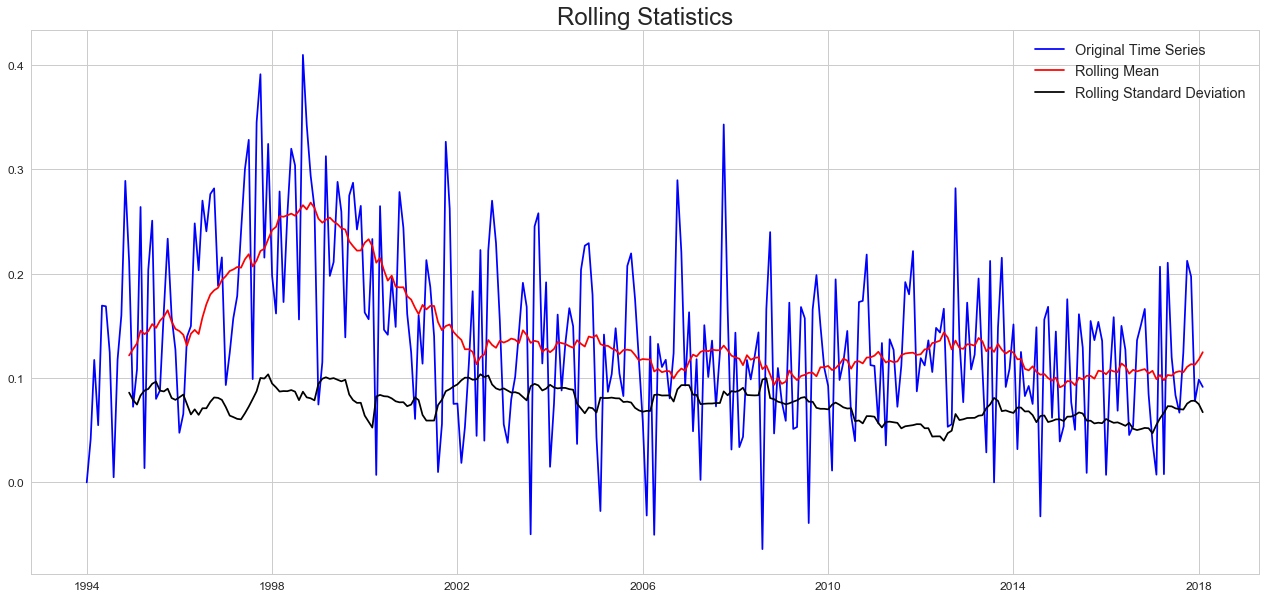

Results of Dickey-Fuller Test:
Test Statistic                  -1.310878
p-value                          0.624181
Number of Lags Used             14.000000
Number of Observations Used    275.000000
Critical Value (1%)             -3.454355
Critical Value (5%)             -2.872108
Critical Value (10%)            -2.572401
dtype: float64


In [15]:
# Removing the exponentially weighted mean from the series
submissions_log_ewa = submissions_log - ewa
submissions_log_ewa.dropna(inplace=True)
ts.test_stationarity(submissions_log_ewa)

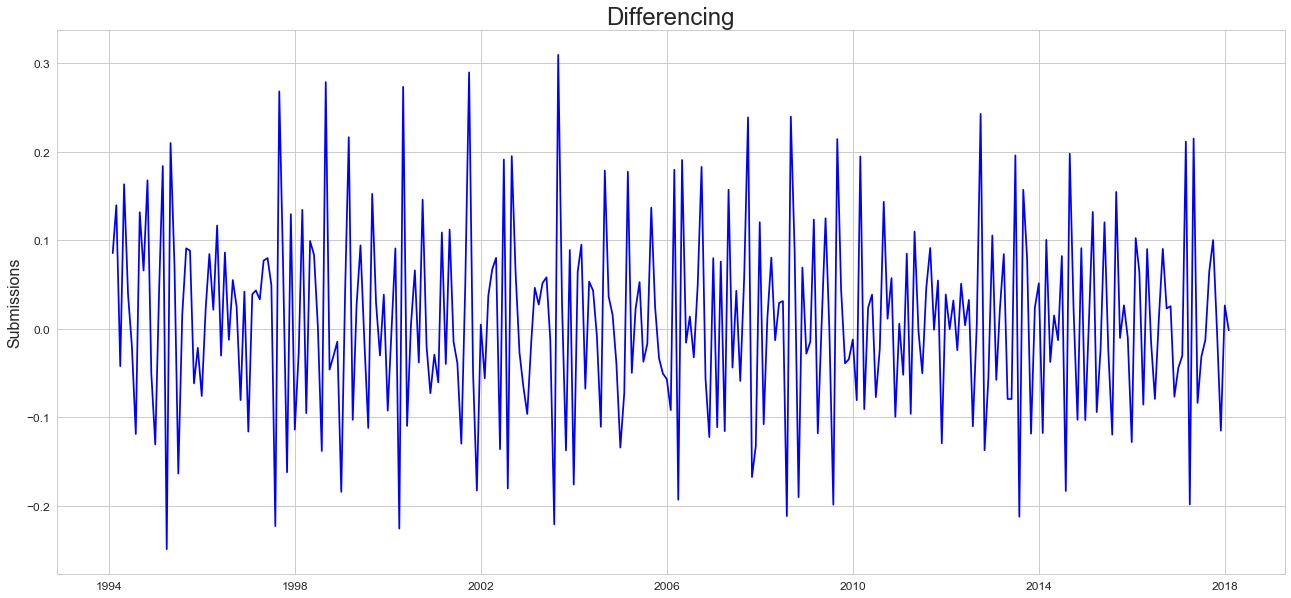

In [16]:
# Differencing
submissions_log_diff_shift = submissions_log - submissions_log.shift()
ts.plot_series(submissions_log_diff_shift, title='Differencing', ylabel='Submissions')

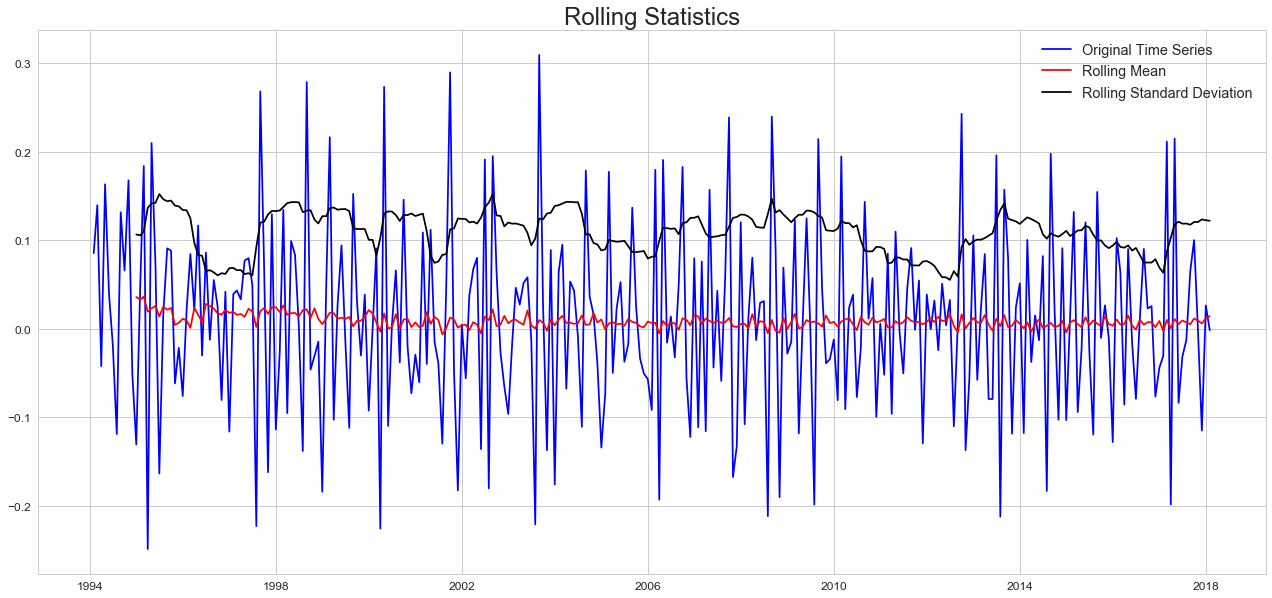

Results of Dickey-Fuller Test:
Test Statistic                  -5.603254
p-value                          0.000001
Number of Lags Used             13.000000
Number of Observations Used    275.000000
Critical Value (1%)             -3.454355
Critical Value (5%)             -2.872108
Critical Value (10%)            -2.572401
dtype: float64


In [17]:
submissions_log_diff_shift.dropna(inplace=True)
ts.test_stationarity(submissions_log_diff_shift)

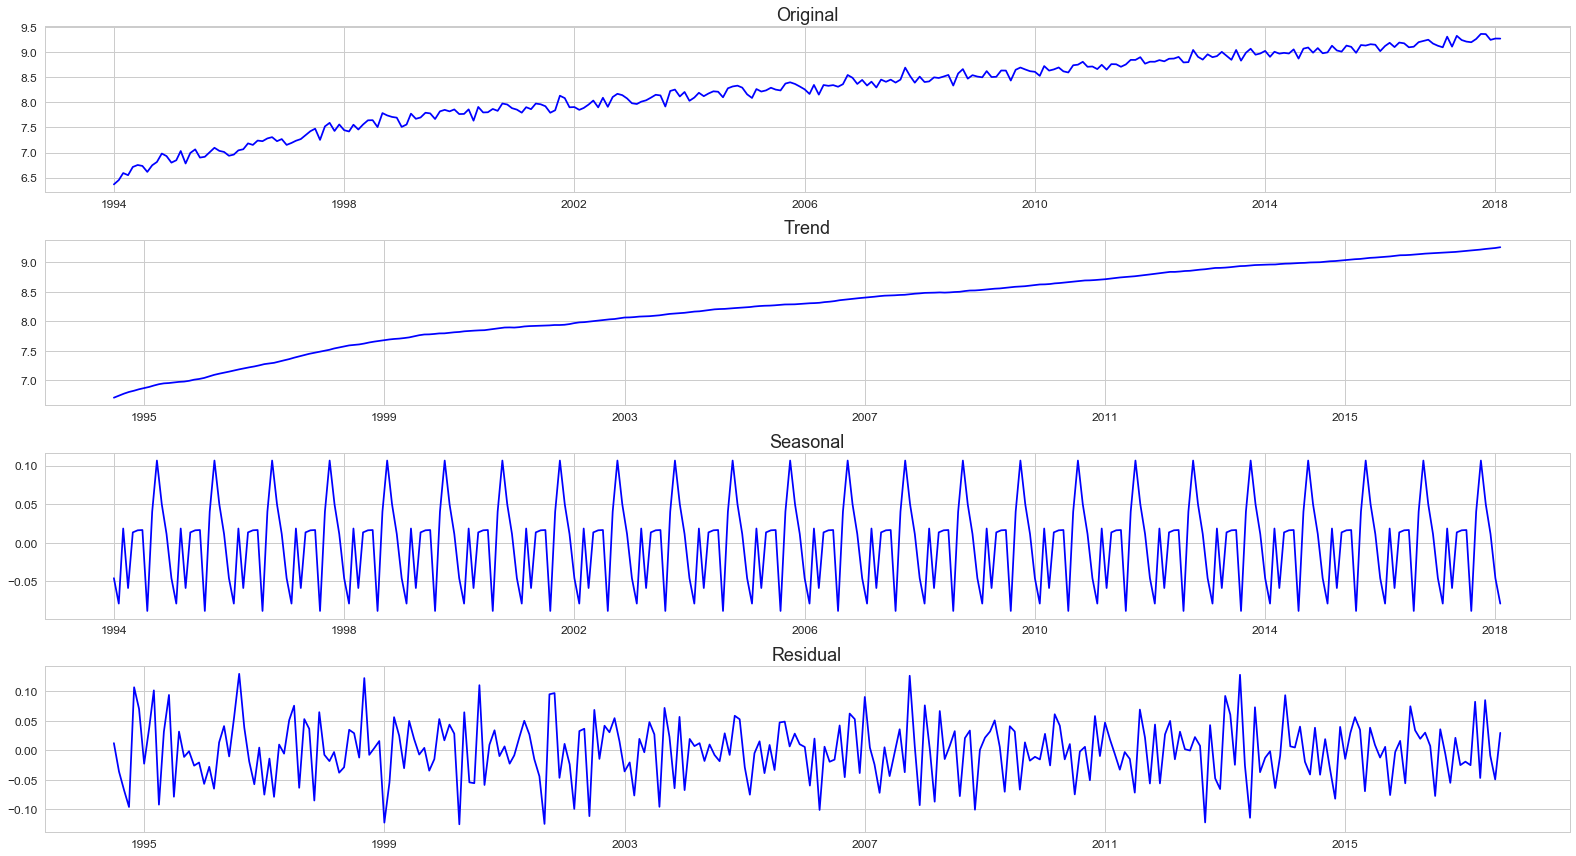

In [18]:
# Decomposing
decomposition = seasonal_decompose(submissions_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plotting
plt.figure(figsize=(22, 12))
# Original
plt.subplot(411)
plt.plot(submissions_log, color='blue')
plt.title('Original', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Trend
plt.subplot(412)
plt.plot(trend, color='blue')
plt.title('Trend', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Seasonal
plt.subplot(413)
plt.plot(seasonal, color='blue')
plt.title('Seasonal', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Residual
plt.subplot(414)
plt.plot(residual, color='blue')
plt.title('Residual', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

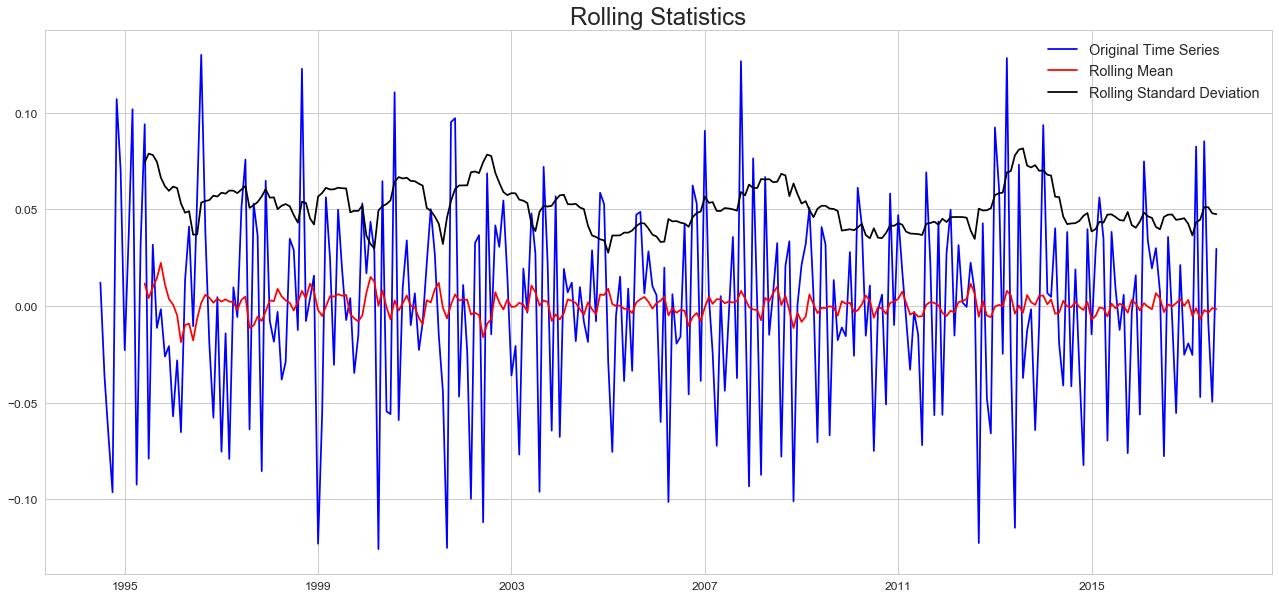

Results of Dickey-Fuller Test:
Test Statistic                -9.666361e+00
p-value                        1.312003e-16
Number of Lags Used            1.500000e+01
Number of Observations Used    2.620000e+02
Critical Value (1%)           -3.455558e+00
Critical Value (5%)           -2.872636e+00
Critical Value (10%)          -2.572683e+00
dtype: float64


In [19]:
# Checking stationarity of residuals
submissions_log_decompose_res = residual
submissions_log_decompose_res.dropna(inplace=True)
ts.test_stationarity(submissions_log_decompose_res)

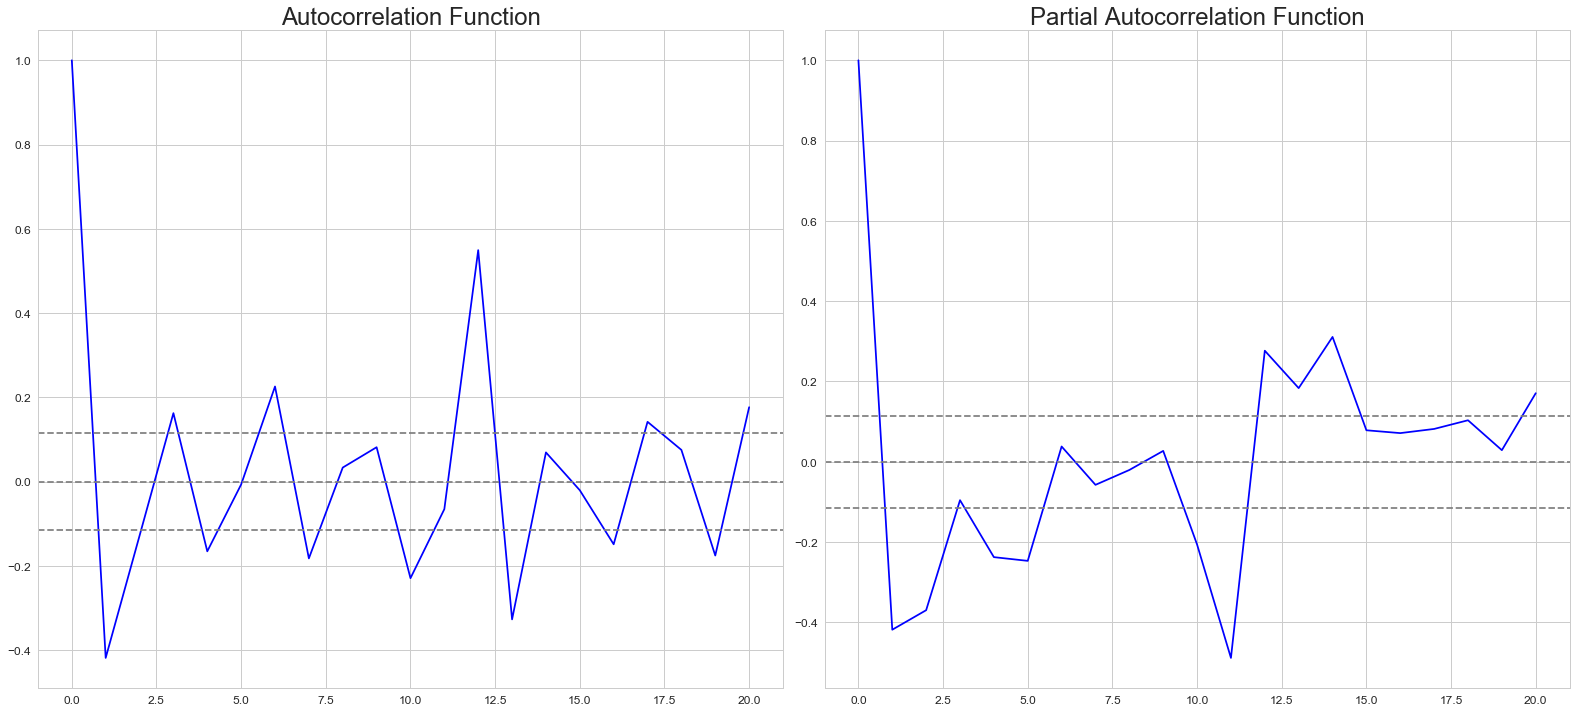

In [20]:
# Forecasting
# ACF and PACF plots:
lag_acf = acf(submissions_log_diff_shift, nlags=20)
lag_pacf = pacf(submissions_log_diff_shift, nlags=20, method='ols')

# Plotting ACF
plt.figure(figsize=(22, 10))
plt.subplot(121)
plt.plot(lag_acf, color='blue')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(submissions_log)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(submissions_log)), linestyle='--', color='gray')
plt.title('Autocorrelation Function', fontsize=24)

# Plotting PACF
plt.subplot(122)
plt.plot(lag_pacf, color='blue')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(submissions_log)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(submissions_log)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function', fontsize=24)
plt.tight_layout()

(array([-0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8]),
 <a list of 9 Text yticklabel objects>)

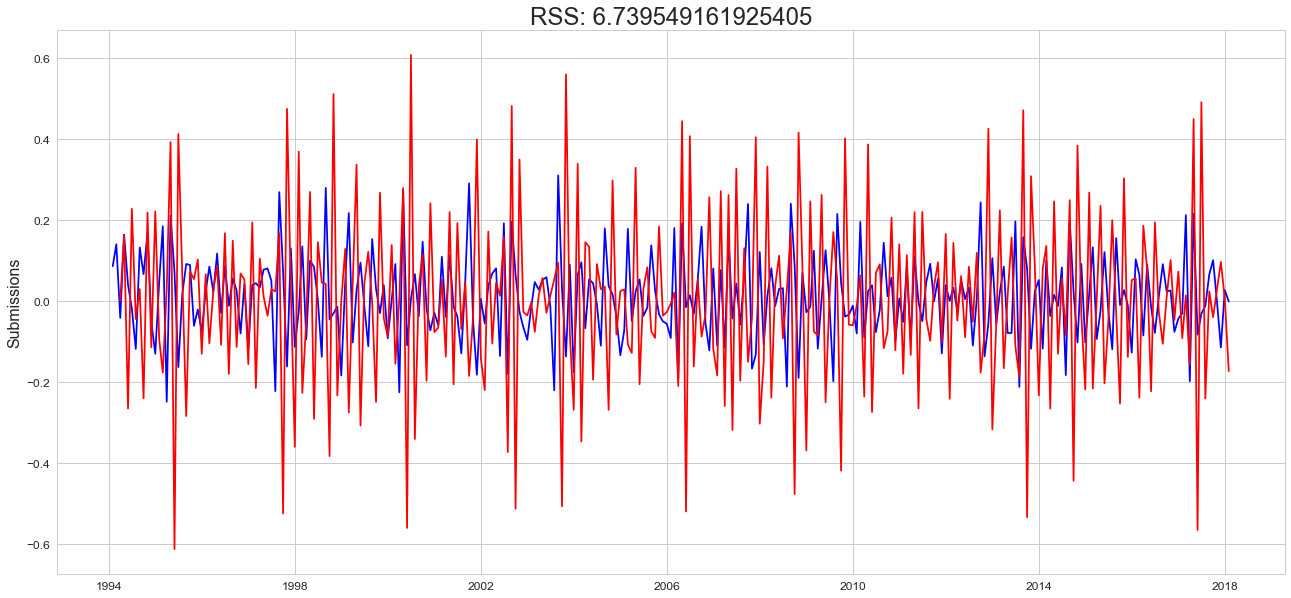

In [21]:
# AR Model
filterwarnings('ignore')
model = ARIMA(submissions_log_diff_shift, order=(1, 2, 0))
results_AR = model.fit(disp=-1)
plt.figure(figsize=(22, 10))
plt.plot(submissions_log_diff_shift, color='blue')
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: {}'.format(sum((results_AR.fittedvalues - submissions_log_diff_shift).fillna(0))**2), fontsize=24)
plt.xticks(fontsize=12)
plt.ylabel('Submissions', fontsize=16)
plt.yticks(fontsize=12)

In [22]:
print(results_AR.summary())

                             ARIMA Model Results                              
Dep. Variable:         D2.submissions   No. Observations:                  287
Model:                 ARIMA(1, 2, 0)   Log Likelihood                   9.375
Method:                       css-mle   S.D. of innovations              0.234
Date:                Wed, 27 Jun 2018   AIC                            -12.749
Time:                        16:12:50   BIC                             -1.771
Sample:                    04-01-1994   HQIC                            -8.349
                         - 02-01-2018                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0003      0.008      0.035      0.972      -0.016       0.016
ar.L1.D2.submissions    -0.6874      0.043    -16.121      0.000      -0.771      -0.604
            

(array([-0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4]),
 <a list of 8 Text yticklabel objects>)

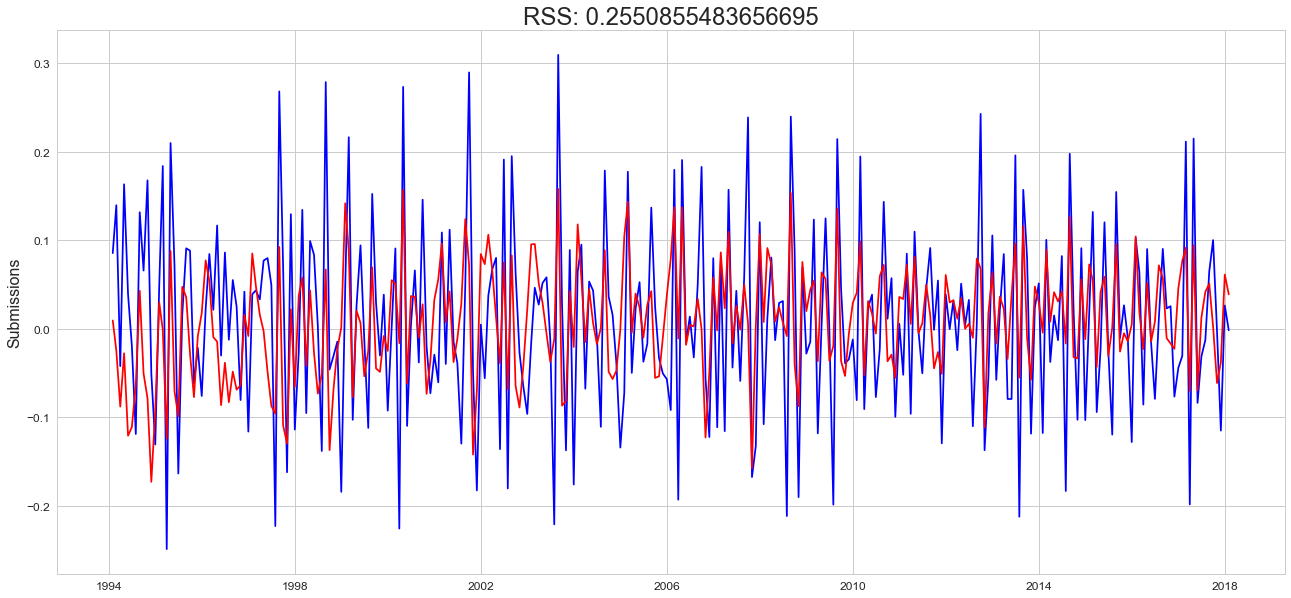

In [23]:
# MA Model
filterwarnings('ignore')
model = ARIMA(submissions_log, order=(0, 1, 2))
results_MA = model.fit(disp=-1)
plt.figure(figsize=(22, 10))
plt.plot(submissions_log_diff_shift, color='blue')
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: {}'.format(sum((results_MA.fittedvalues - submissions_log_diff_shift).fillna(0))**2), fontsize=24)
plt.xticks(fontsize=12)
plt.ylabel('Submissions', fontsize=16)
plt.yticks(fontsize=12)

In [24]:
print(results_MA.summary())

                             ARIMA Model Results                              
Dep. Variable:          D.submissions   No. Observations:                  289
Model:                 ARIMA(0, 1, 2)   Log Likelihood                 296.874
Method:                       css-mle   S.D. of innovations              0.086
Date:                Wed, 27 Jun 2018   AIC                           -585.749
Time:                        16:12:51   BIC                           -571.083
Sample:                    02-01-1994   HQIC                          -579.872
                         - 02-01-2018                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0095      0.001      8.164      0.000       0.007       0.012
ma.L1.D.submissions    -0.7157      0.065    -11.004      0.000      -0.843      -0.588
ma.L2.D.submissi

(array([-0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4]),
 <a list of 8 Text yticklabel objects>)

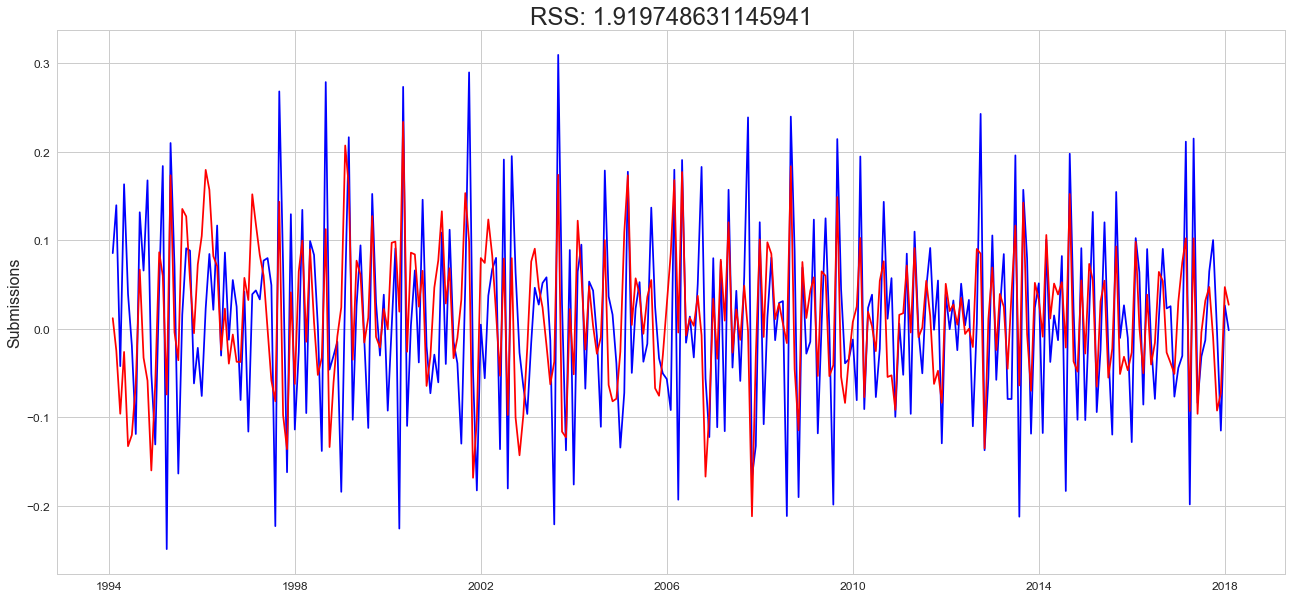

In [25]:
# ARIMA Model
filterwarnings('ignore')
model = ARIMA(submissions_log, order=(1, 1, 2))
results_ARIMA = model.fit(disp=-1)
plt.figure(figsize=(22, 10))
plt.plot(submissions_log_diff_shift, color='blue')
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: {}'.format(sum((results_ARIMA.fittedvalues - submissions_log_diff_shift).fillna(0))**2), fontsize=24)
plt.xticks(fontsize=12)
plt.ylabel('Submissions', fontsize=16)
plt.yticks(fontsize=12)

In [26]:
print(results_ARIMA.summary())

                             ARIMA Model Results                              
Dep. Variable:          D.submissions   No. Observations:                  289
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 306.120
Method:                       css-mle   S.D. of innovations              0.083
Date:                Wed, 27 Jun 2018   AIC                           -602.240
Time:                        16:12:52   BIC                           -583.908
Sample:                    02-01-1994   HQIC                          -594.894
                         - 02-01-2018                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0121      0.005      2.481      0.014       0.003       0.022
ar.L1.D.submissions     0.9914      0.010     96.501      0.000       0.971       1.012
ma.L1.D.submissi

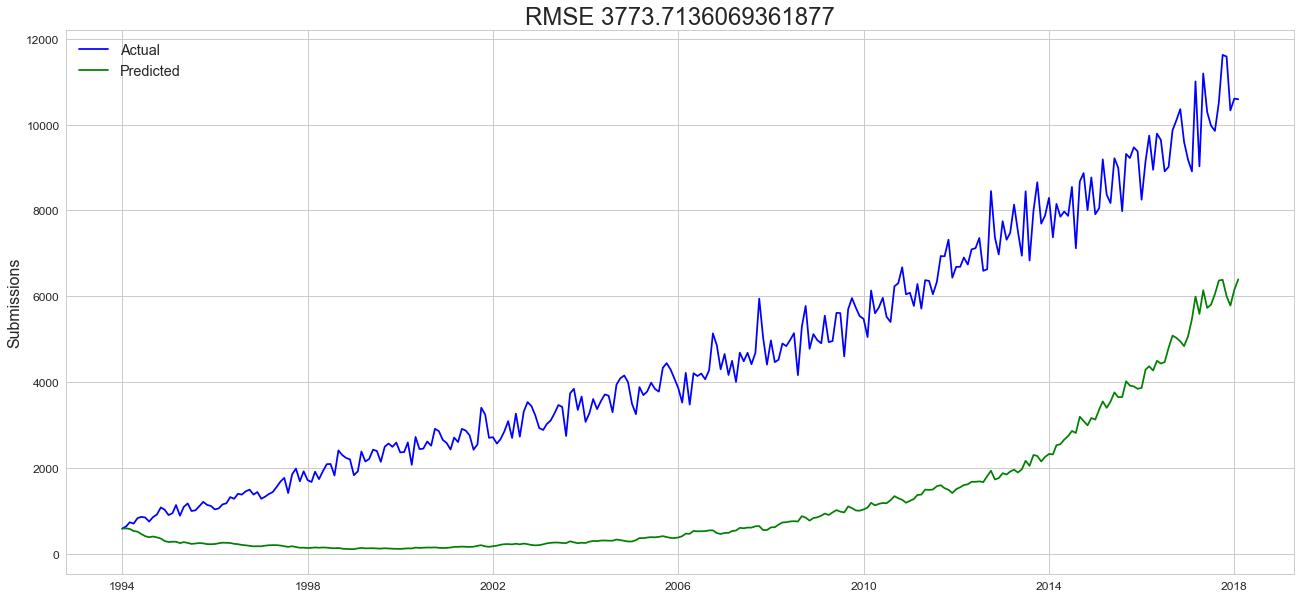

In [27]:
# Reversing to the original scale
predictions_MA_diff = pd.Series(results_MA.fittedvalues, copy=True)

# Cumulative sum
predictions_MA_diff_cumsum = predictions_MA_diff.cumsum()

# Adding the base number
predictions_MA_log = pd.Series(submissions_log.ix[0], index=submissions_log.index)
predictions_MA_log = predictions_MA_log.add(predictions_MA_diff_cumsum, fill_value=0)

# Taking the exponent
predictions_MA = np.exp(predictions_MA_log)
plt.figure(figsize=(22, 10))
plt.plot(submissions, color='blue')
plt.plot(predictions_MA, color='green')
plt.title('RMSE {}'.format(np.sqrt(sum((predictions_MA - submissions)**2)/len(submissions))), fontsize=24)
plt.xticks(fontsize=12)
plt.ylabel('Submissions', fontsize=16)
plt.yticks(fontsize=12)
plt.legend(['Actual', 'Predicted'], fontsize='x-large')

### Summary

**insert summary here**

***

### Downloads

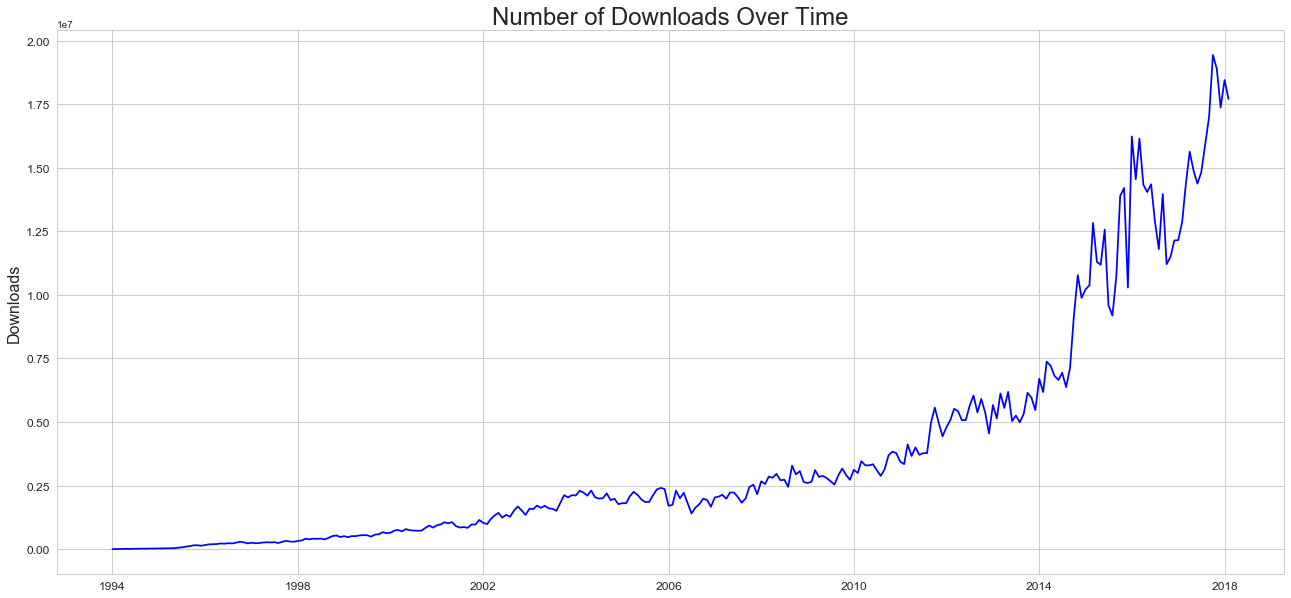

In [28]:
# Creating the time series
d = data[['month', 'downloads']]
downloads = d.set_index('month')['downloads']

# Number of downloads over time
ts.plot_series(downloads, title='Number of Downloads Over Time', ylabel='Downloads')

Over time, downloads show a rising trend from $1995$ and gained a lot of momentum in $2012$. The years after $2012$ show significant increases, however there is a decrease in $2016$. After the drop in $2016$, the number of downloads rises even higher reaching a peak of close to 2 million downloads towards the end of $2017$.

#### Stationarity of Downloads

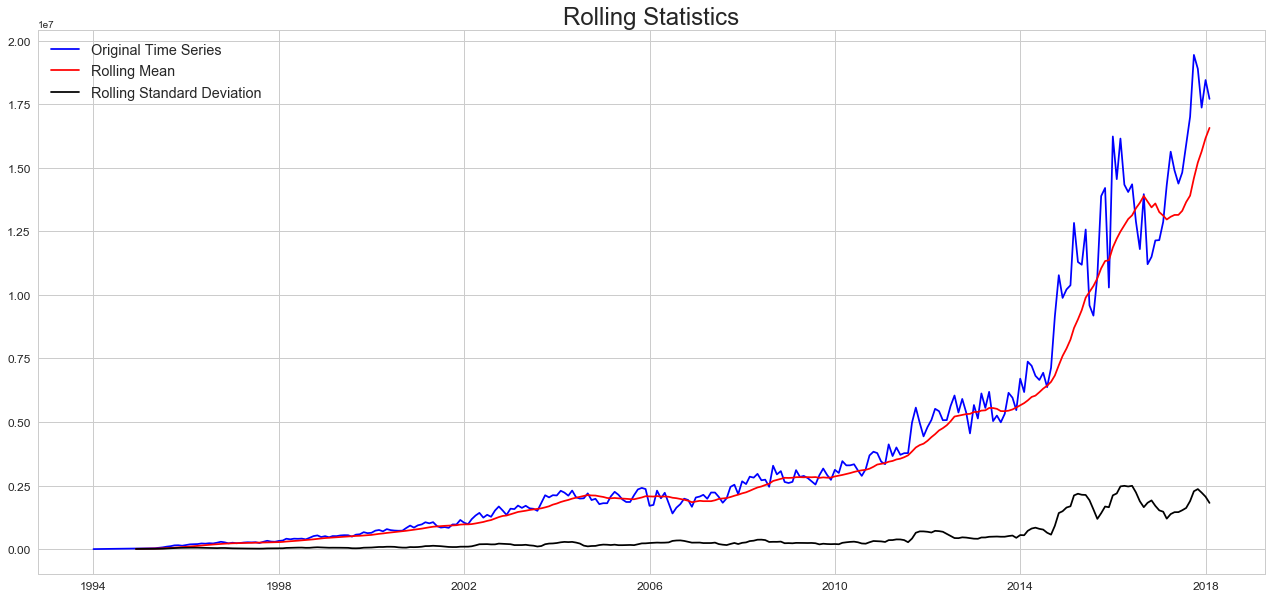

Results of Dickey-Fuller Test:
Test Statistic                   4.001266
p-value                          1.000000
Number of Lags Used             10.000000
Number of Observations Used    279.000000
Critical Value (1%)             -3.454008
Critical Value (5%)             -2.871956
Critical Value (10%)            -2.572320
dtype: float64


In [29]:
ts.test_stationarity(downloads)

The Dickey-Fuller test shows a high test statistic relative to the sub-zero critical values. This means the number of downloads have a rolling mean that rises over time even though the standard deviation remains relatively low.

We also try to remove the trend in the downloads data by apply logarithms.

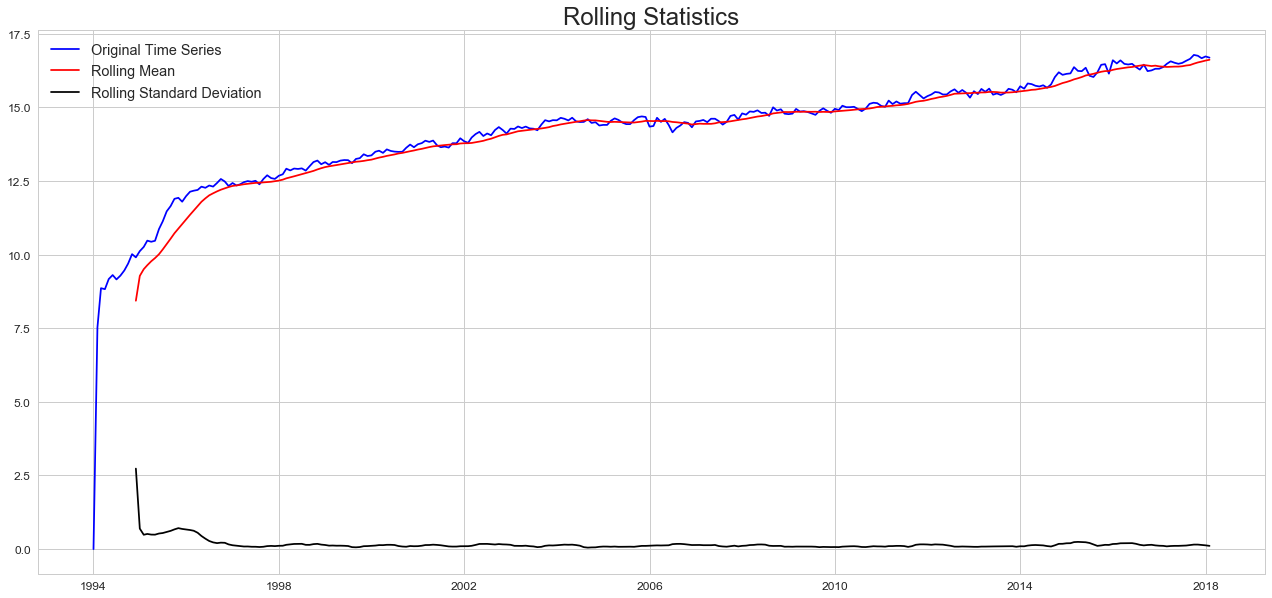

Results of Dickey-Fuller Test:
Test Statistic                  -1.570731
p-value                          0.498278
Number of Lags Used             16.000000
Number of Observations Used    273.000000
Critical Value (1%)             -3.454533
Critical Value (5%)             -2.872186
Critical Value (10%)            -2.572443
dtype: float64


In [30]:
# Removing seasonality and trend
downloads_log = np.log(downloads)
downloads_log = downloads_log.replace(np.negative(np.inf), 0)
downloads_log.dropna(inplace=True)
ts.test_stationarity(downloads_log)

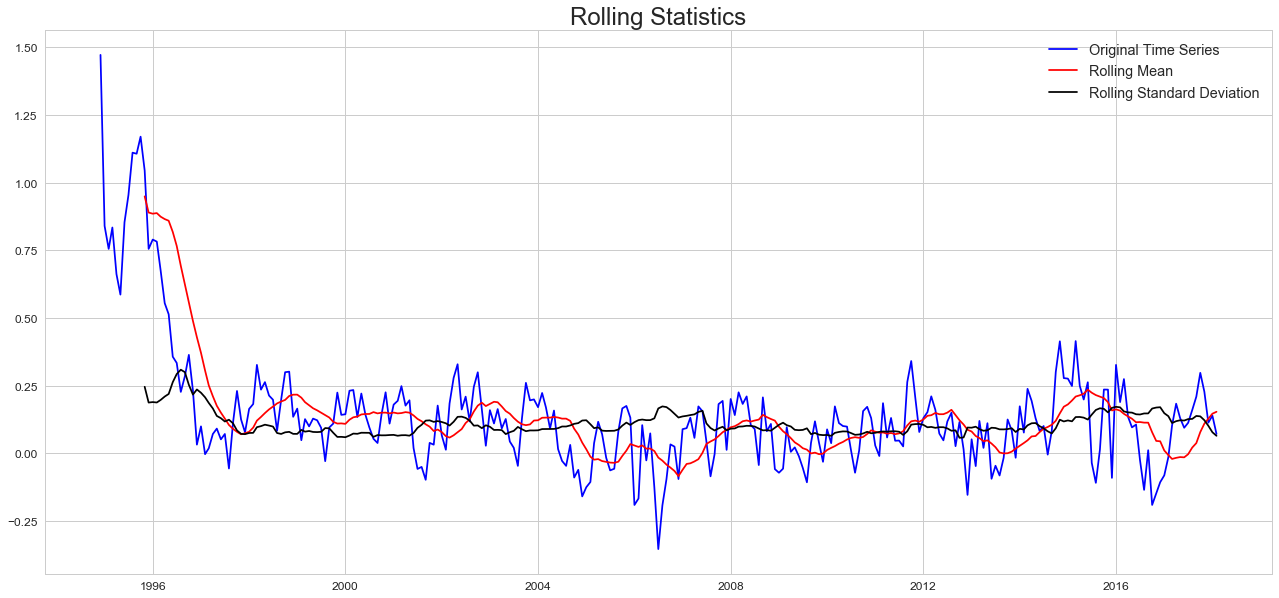

Results of Dickey-Fuller Test:
Test Statistic                  -5.393559
p-value                          0.000003
Number of Lags Used             12.000000
Number of Observations Used    266.000000
Critical Value (1%)             -3.455175
Critical Value (5%)             -2.872468
Critical Value (10%)            -2.572593
dtype: float64


In [31]:
# Removing the rolling mean
downloads_log_diff = downloads_log - downloads_log.rolling(window=12, center=False).mean().dropna()
downloads_log_diff.dropna(inplace=True)
ts.test_stationarity(downloads_log_diff)

(array([ -2.5,   0. ,   2.5,   5. ,   7.5,  10. ,  12.5,  15. ,  17.5,  20. ]),
 <a list of 10 Text yticklabel objects>)

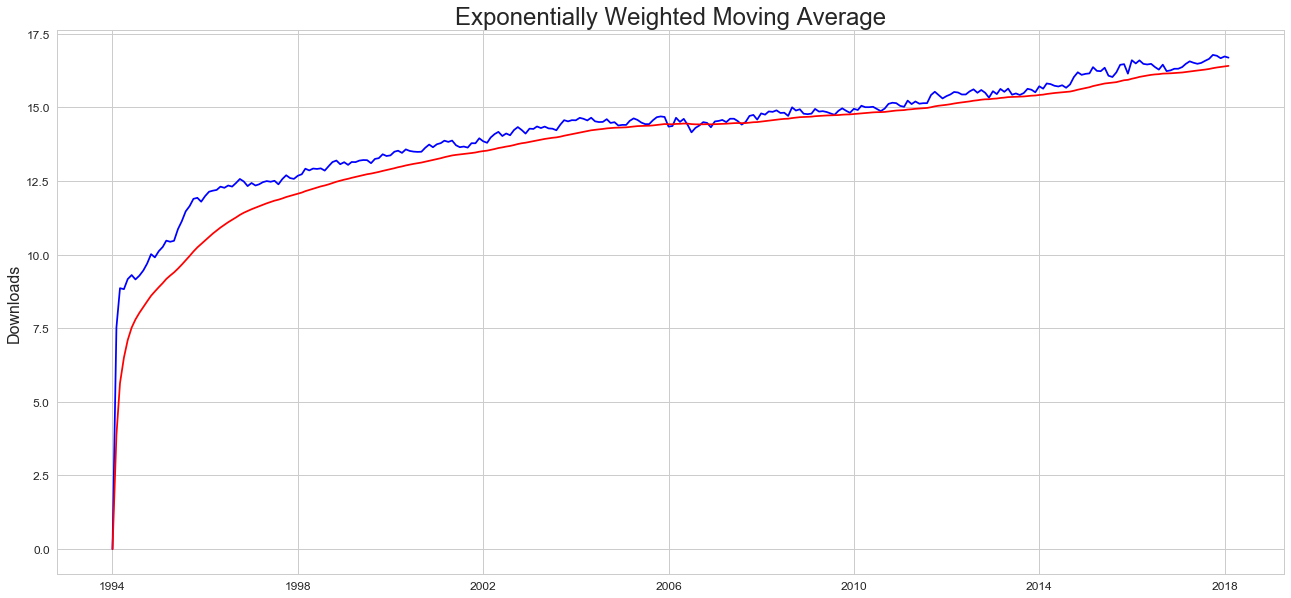

In [32]:
# Exponentially weighted moving average
ewa = downloads_log.ewm(halflife=12).mean()
plt.figure(figsize=(22, 10))
plt.plot(downloads_log, color='blue')
plt.plot(ewa, color='red')
plt.title('Exponentially Weighted Moving Average', fontsize=24)
plt.xticks(fontsize=12)
plt.ylabel('Downloads', fontsize=16)
plt.yticks(fontsize=12)

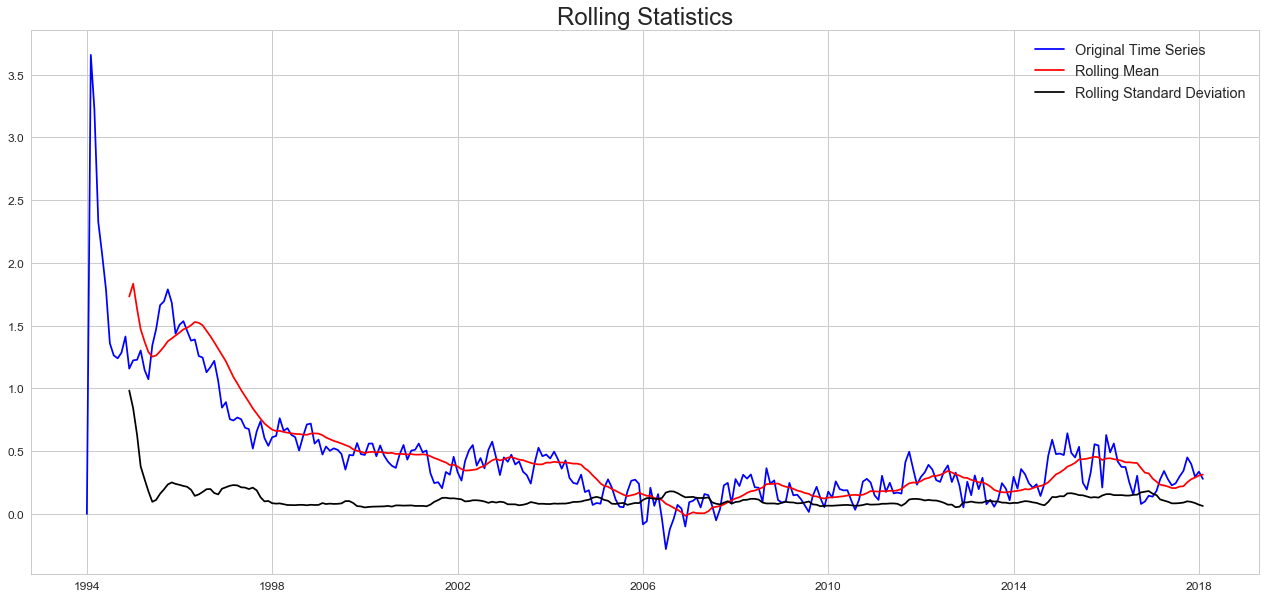

Results of Dickey-Fuller Test:
Test Statistic                  -2.936823
p-value                          0.041231
Number of Lags Used             15.000000
Number of Observations Used    274.000000
Critical Value (1%)             -3.454444
Critical Value (5%)             -2.872147
Critical Value (10%)            -2.572422
dtype: float64


In [33]:
# Removing the exponentially weighted mean from the series
downloads_log_ewa = downloads_log - ewa
downloads_log_ewa.dropna(inplace=True)
ts.test_stationarity(downloads_log_ewa)

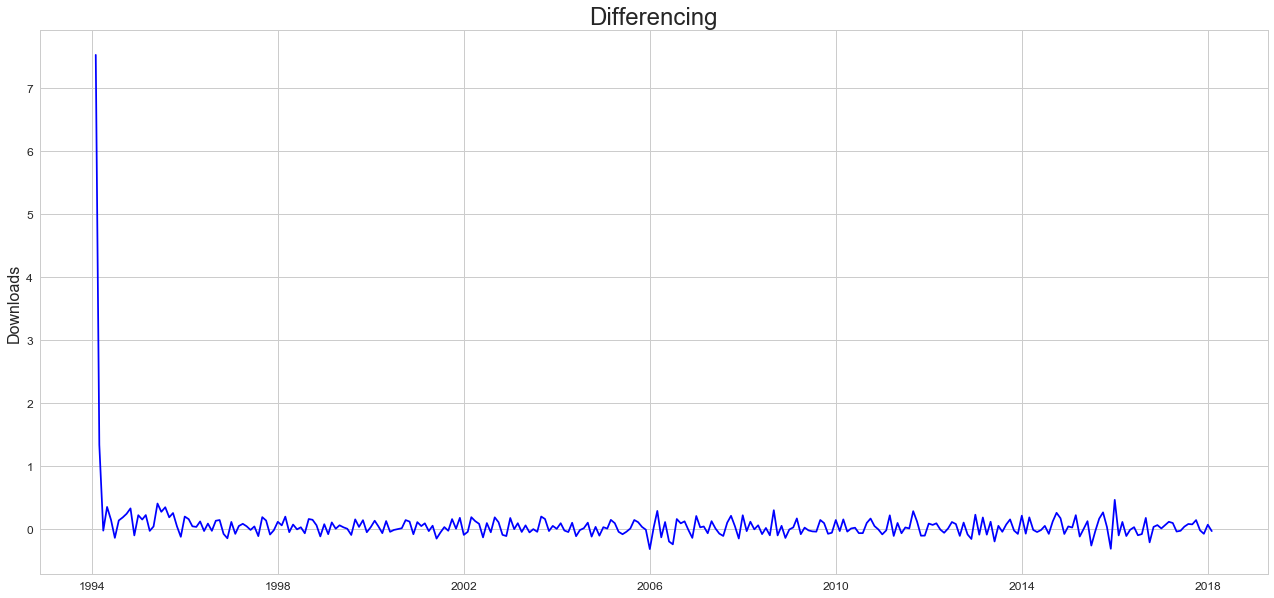

In [34]:
# Differencing
downloads_log_diff_shift = downloads_log - downloads_log.shift()
ts.plot_series(downloads_log_diff_shift, title='Differencing', ylabel='Downloads')

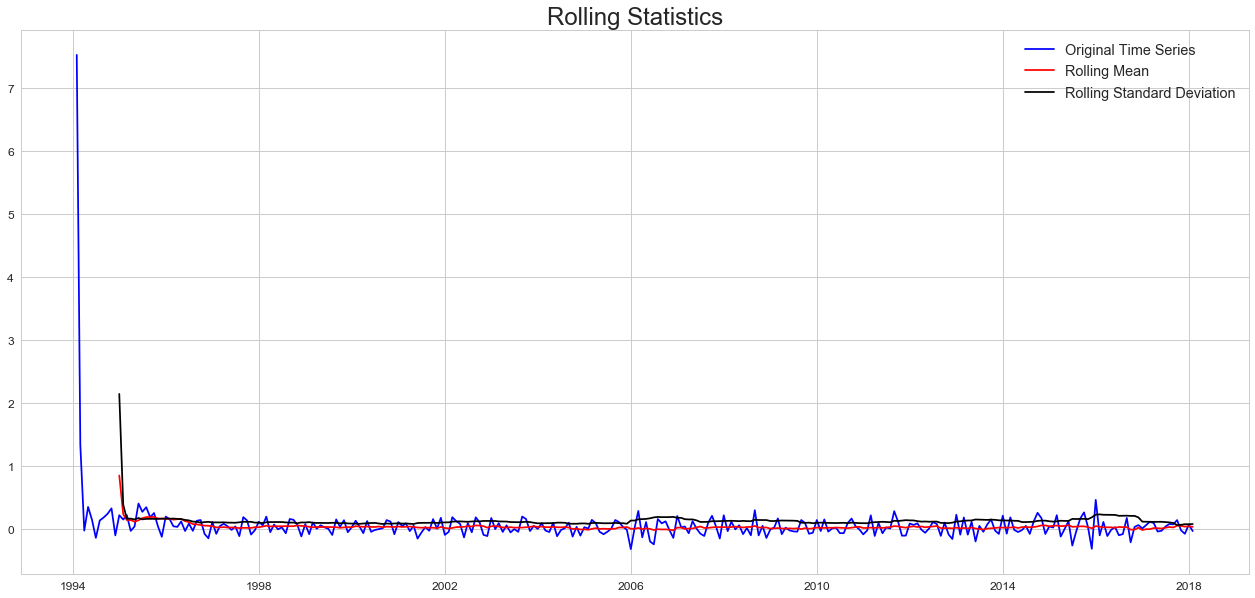

Results of Dickey-Fuller Test:
Test Statistic                  -4.337523
p-value                          0.000382
Number of Lags Used             16.000000
Number of Observations Used    272.000000
Critical Value (1%)             -3.454622
Critical Value (5%)             -2.872225
Critical Value (10%)            -2.572464
dtype: float64


In [35]:
downloads_log_diff_shift.dropna(inplace=True)
ts.test_stationarity(downloads_log_diff_shift)

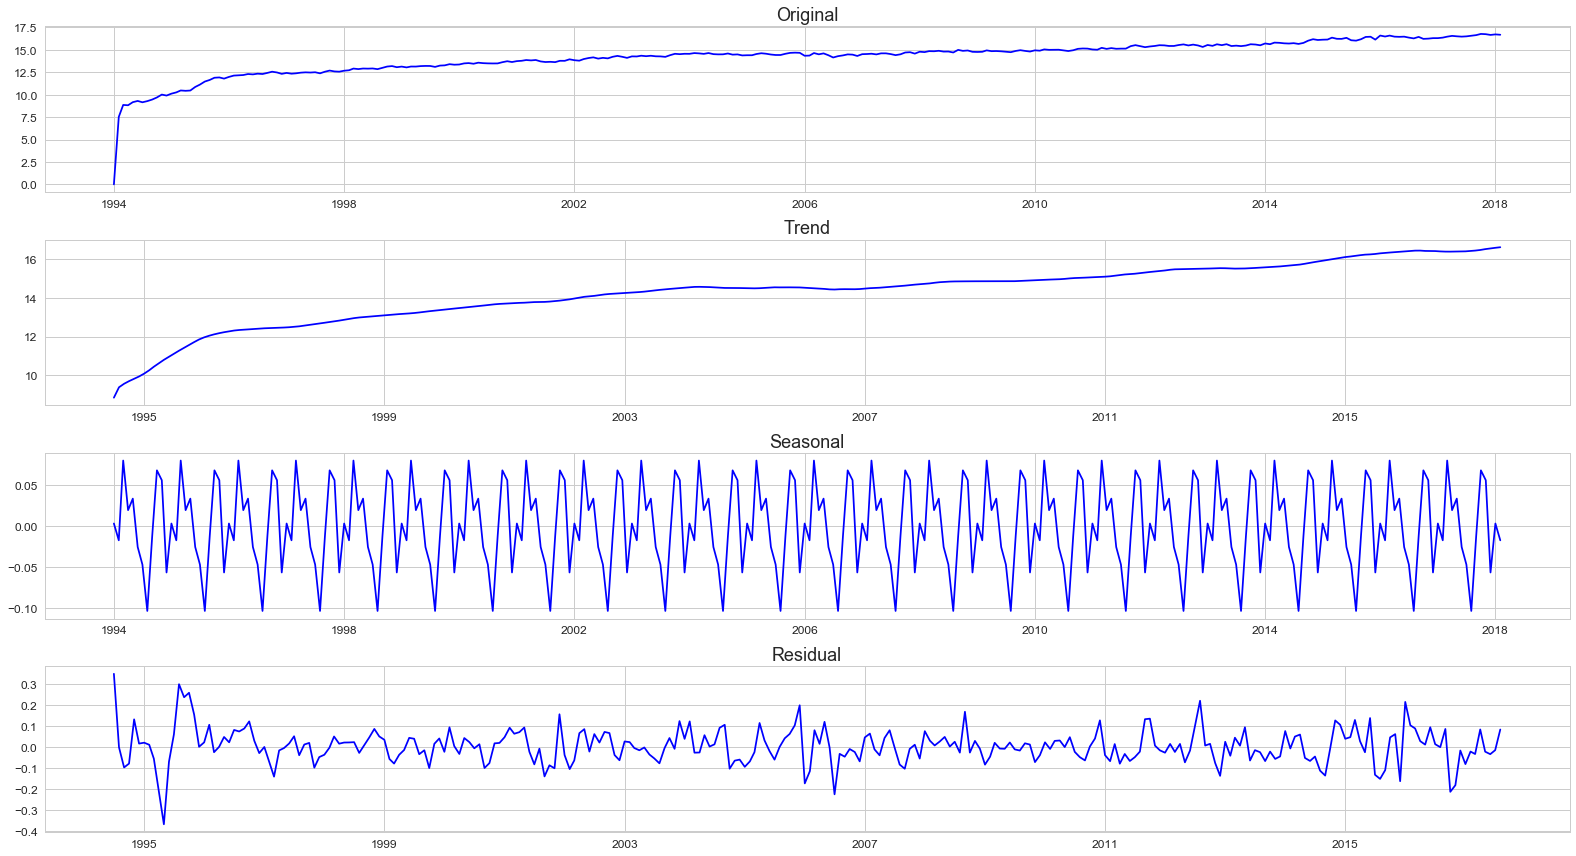

In [36]:
# Decomposing
decomposition = seasonal_decompose(downloads_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plotting
plt.figure(figsize=(22, 12))
# Original
plt.subplot(411)
plt.plot(downloads_log, color='blue')
plt.title('Original', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Trend
plt.subplot(412)
plt.plot(trend, color='blue')
plt.title('Trend', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Seasonal
plt.subplot(413)
plt.plot(seasonal, color='blue')
plt.title('Seasonal', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Residual
plt.subplot(414)
plt.plot(residual, color='blue')
plt.title('Residual', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

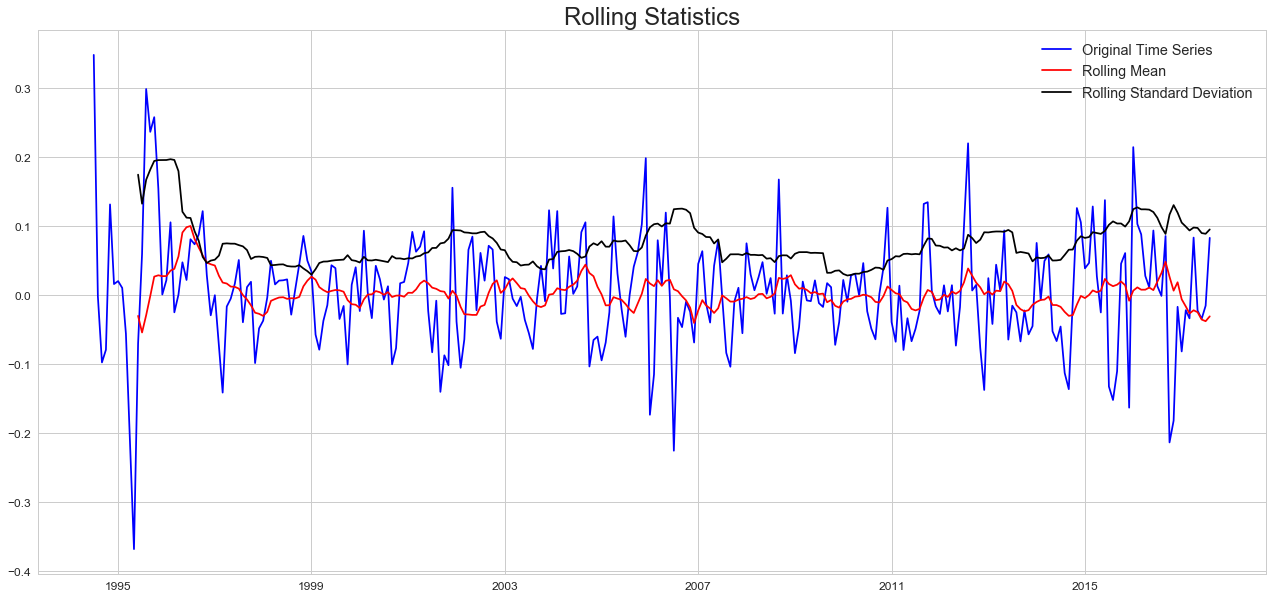

Results of Dickey-Fuller Test:
Test Statistic                -1.235573e+01
p-value                        5.692150e-23
Number of Lags Used            0.000000e+00
Number of Observations Used    2.770000e+02
Critical Value (1%)           -3.454180e+00
Critical Value (5%)           -2.872031e+00
Critical Value (10%)          -2.572360e+00
dtype: float64


In [37]:
# Checking stationarity of residuals
downloads_log_decompose_res = residual
downloads_log_decompose_res.dropna(inplace=True)
ts.test_stationarity(downloads_log_decompose_res)

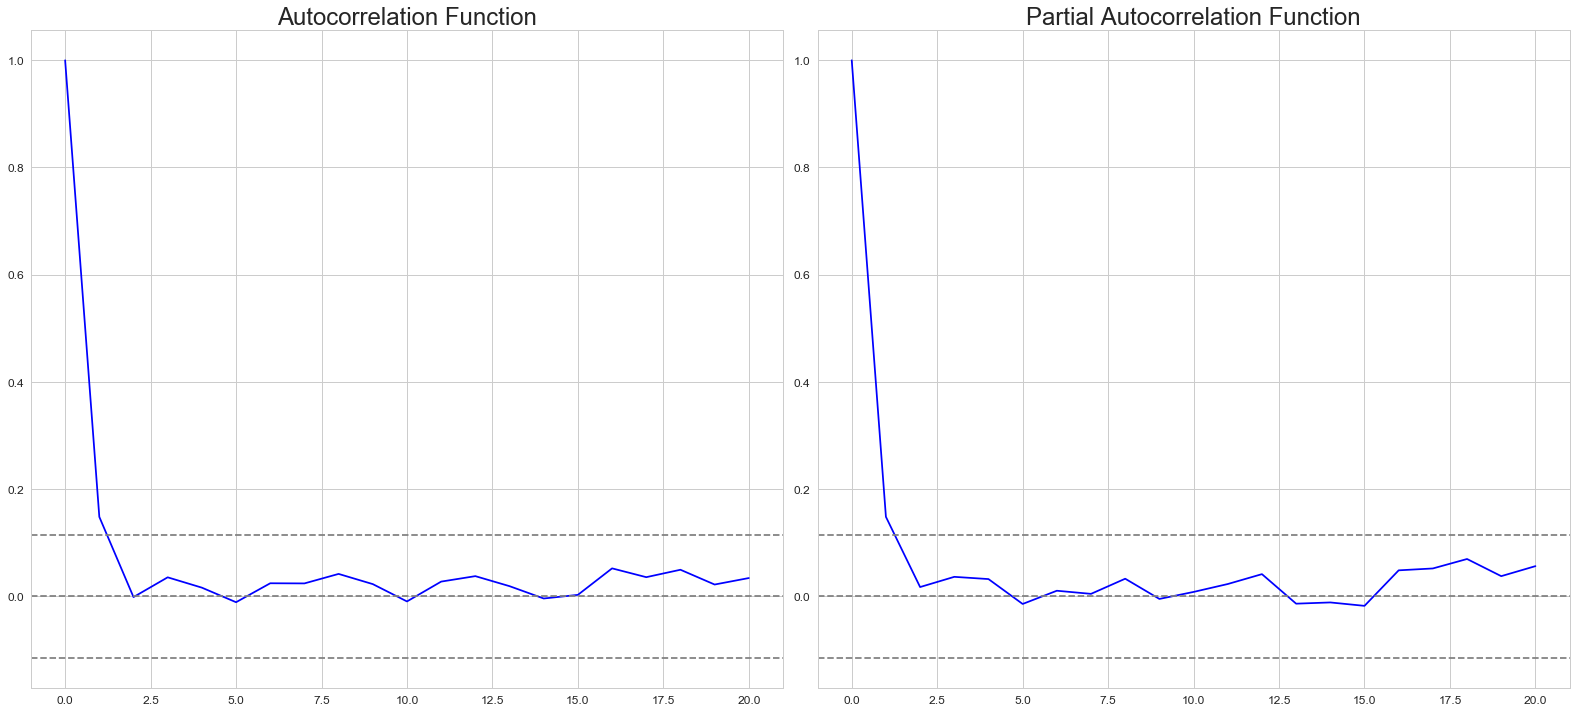

In [38]:
# Forecasting
# ACF and PACF plots:
lag_acf = acf(downloads_log_diff_shift, nlags=20)
lag_pacf = pacf(downloads_log_diff_shift, nlags=20, method='ols')

# Plotting ACF
plt.figure(figsize=(22, 10))
plt.subplot(121)
plt.plot(lag_acf, color='blue')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(downloads_log)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(downloads_log)), linestyle='--', color='gray')
plt.title('Autocorrelation Function', fontsize=24)

# Plotting PACF
plt.subplot(122)
plt.plot(lag_pacf, color='blue')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(downloads_log)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(downloads_log)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function', fontsize=24)
plt.tight_layout()

(array([-4., -2.,  0.,  2.,  4.,  6.,  8.]),
 <a list of 7 Text yticklabel objects>)

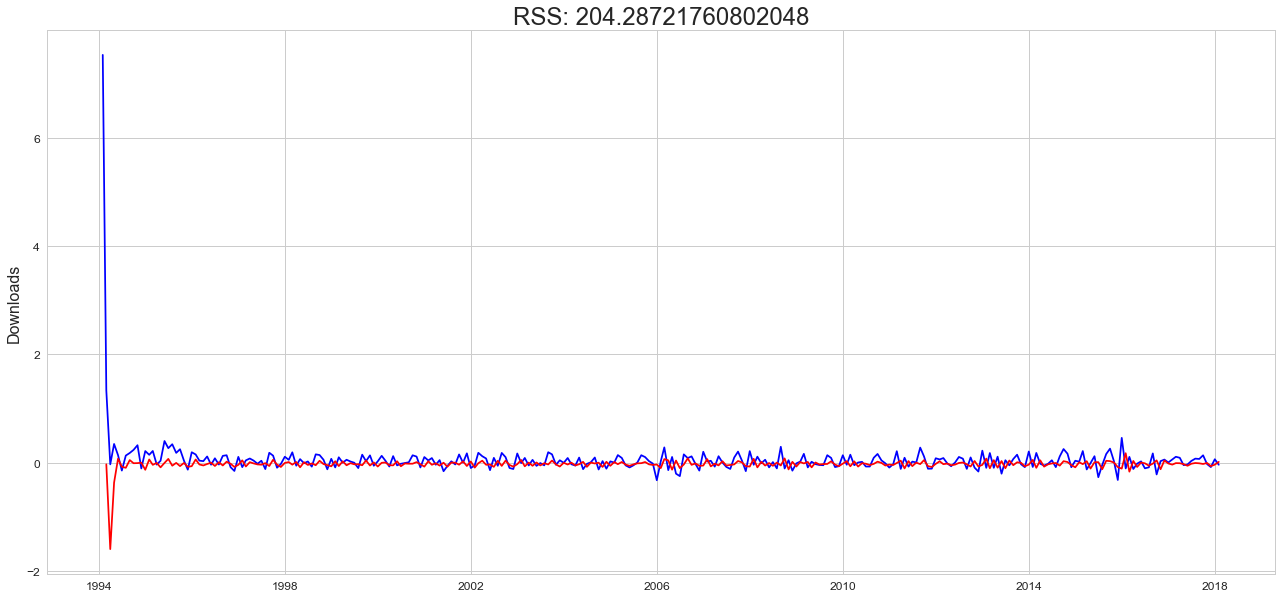

In [39]:
# AR Model
filterwarnings('ignore')
model = ARIMA(downloads_log_diff_shift, order=(1, 1, 0))
results_AR = model.fit(disp=-1)
plt.figure(figsize=(22, 10))
plt.plot(downloads_log_diff_shift, color='blue')
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: {}'.format(sum((results_MA.fittedvalues - downloads_log_diff_shift).fillna(0))**2), fontsize=24)
plt.xticks(fontsize=12)
plt.ylabel('Downloads', fontsize=16)
plt.yticks(fontsize=12)

In [40]:
print(results_AR.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.downloads   No. Observations:                  288
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -152.478
Method:                       css-mle   S.D. of innovations              0.411
Date:                Wed, 27 Jun 2018   AIC                            310.956
Time:                        16:12:56   BIC                            321.945
Sample:                    03-01-1994   HQIC                           315.360
                         - 02-01-2018                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0337      0.033     -1.028      0.305      -0.098       0.031
ar.L1.D.downloads     0.2539      0.122      2.078      0.039       0.014       0.493
                        

(array([-2.,  0.,  2.,  4.,  6.,  8.]), <a list of 6 Text yticklabel objects>)

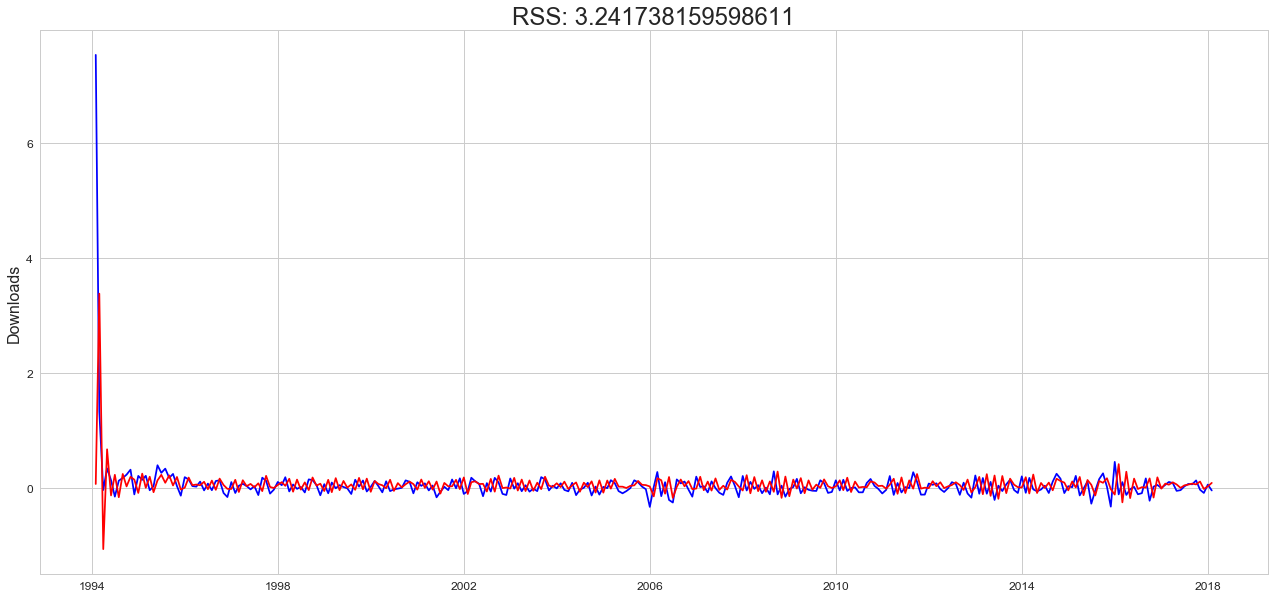

In [41]:
# MA Model
filterwarnings('ignore')
model = ARIMA(downloads_log, order=(0, 1, 1))
results_MA = model.fit(disp=-1)
plt.figure(figsize=(22, 10))
plt.plot(downloads_log_diff_shift, color='blue')
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: {}'.format(sum((results_MA.fittedvalues - downloads_log_diff_shift).fillna(0))**2), fontsize=24)
plt.xticks(fontsize=12)
plt.ylabel('Downloads', fontsize=16)
plt.yticks(fontsize=12)

In [42]:
print(results_MA.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.downloads   No. Observations:                  289
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -167.353
Method:                       css-mle   S.D. of innovations              0.431
Date:                Wed, 27 Jun 2018   AIC                            340.705
Time:                        16:12:56   BIC                            351.705
Sample:                    02-01-1994   HQIC                           345.113
                         - 02-01-2018                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0714      0.041      1.752      0.081      -0.008       0.151
ma.L1.D.downloads     0.6070      0.055     10.965      0.000       0.499       0.716
                        

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]),
 <a list of 10 Text yticklabel objects>)

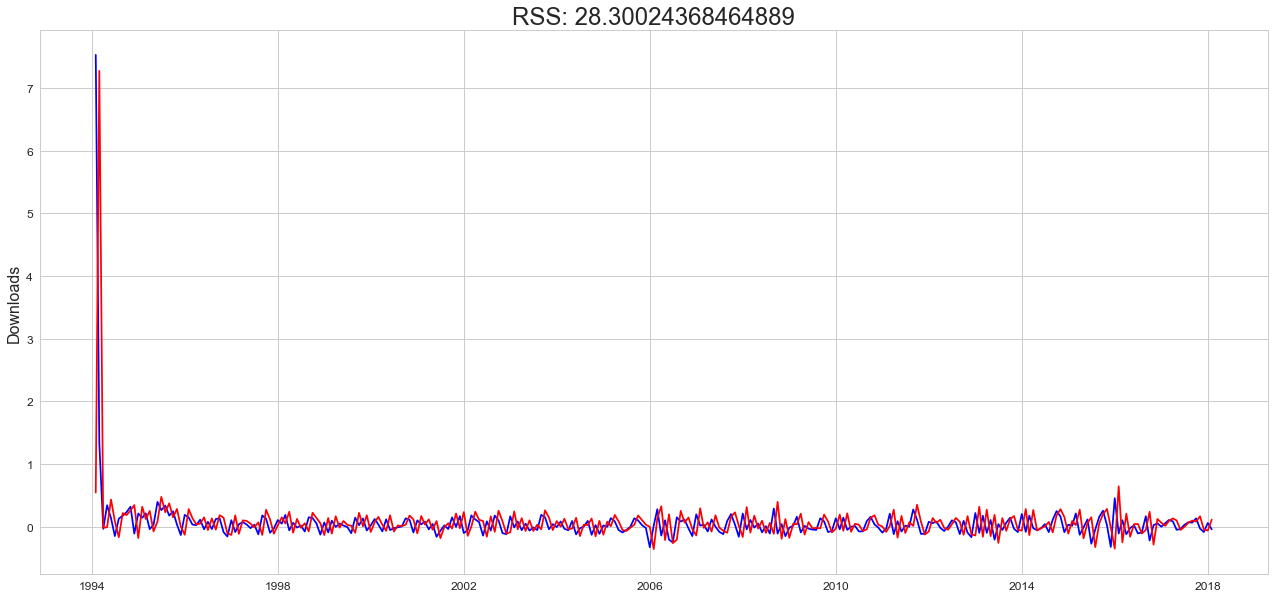

In [43]:
# ARIMA Model
filterwarnings('ignore')
model = ARIMA(downloads_log, order=(1, 1, 1))
results_ARIMA = model.fit(disp=-1)
plt.figure(figsize=(22, 10))
plt.plot(downloads_log_diff_shift, color='blue')
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: {}'.format(sum((results_ARIMA.fittedvalues - downloads_log_diff_shift).fillna(0))**2), fontsize=24)
plt.xticks(fontsize=12)
plt.ylabel('Downloads', fontsize=16)
plt.yticks(fontsize=12)

In [44]:
print(results_ARIMA.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.downloads   No. Observations:                  289
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -154.539
Method:                       css-mle   S.D. of innovations              0.411
Date:                Wed, 27 Jun 2018   AIC                            317.078
Time:                        16:12:57   BIC                            331.744
Sample:                    02-01-1994   HQIC                           322.954
                         - 02-01-2018                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.5464      0.779      0.701      0.484      -0.981       2.074
ar.L1.D.downloads     0.9477      0.066     14.275      0.000       0.818       1.078
ma.L1.D.downloads     0.

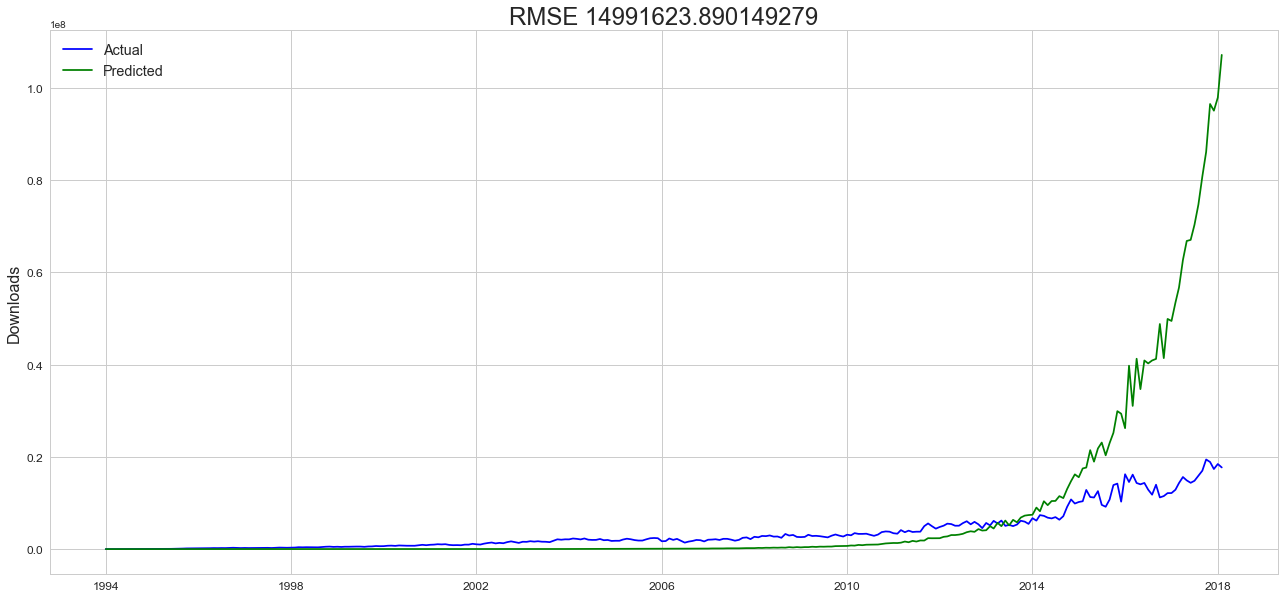

In [45]:
# By MA
# Reversing to the original scale
predictions_MA_diff = pd.Series(results_MA.fittedvalues, copy=True)

# Cumulative sum
predictions_MA_diff_cumsum = predictions_MA_diff.cumsum()

# Adding the base number
predictions_MA_log = pd.Series(downloads_log.ix[0], index=downloads_log.index)
predictions_MA_log = predictions_MA_log.add(predictions_MA_diff_cumsum, fill_value=0)

# Taking the exponent
predictions_MA = np.exp(predictions_MA_log)
plt.figure(figsize=(22, 10))
plt.plot(downloads, color='blue')
plt.plot(predictions_MA, color='green')
plt.title('RMSE {}'.format(np.sqrt(sum((predictions_MA - downloads)**2)/len(downloads))), fontsize=24)
plt.xticks(fontsize=12)
plt.ylabel('Downloads', fontsize=16)
plt.yticks(fontsize=12)
plt.legend(['Actual', 'Predicted'], fontsize='x-large')

### Summary

**insert summary here**

***